# Исследование влияния аугментаций на работу CNN

In [1]:
import torch
import torch.nn as nn
from torch.functional import F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('dark_background')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Скачиваем данные Intel Image Classification с Kaggle

In [2]:
# Классы датасета Intel Image classification
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

train_path = "/kaggle/input/seg_train/seg_train"
val_path = "/kaggle/input/seg_test/seg_test"

train_img_path = []
train_img_label = []
for folder in os.listdir(train_path):
    for img in os.listdir(os.path.join(train_path, folder)):
        train_img_path.append(os.path.join(train_path, folder, img))
        train_img_label.append(classes.index(folder))

val_img_path = []
val_img_label = []
for folder in os.listdir(val_path):
    for img in os.listdir(os.path.join(val_path, folder)):
        val_img_path.append(os.path.join(val_path, folder, img))
        val_img_label.append(classes.index(folder))

# Подготовка датасета (до добавления аугментаций)

In [3]:
# Для работы с библиотекой albumentations придется написать кастомный датасет
class MyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

In [4]:
# Трансформации
train_transform = A.Compose([
    A.Resize(150, 150), # Выдавало ошибку, видимо некоторые изображения отличаются по размеру
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(150, 150),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Dataloaders
train_dataset = MyDataset(image_paths=train_img_path, labels=train_img_label, transform=train_transform)
train_loader = DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0, # Тоже проблему выдавало, оказывается из-за многопоточности
                          pin_memory=True)

val_dataset = MyDataset(image_paths=val_img_path, labels=val_img_label, transform=val_transform)
val_loader = DataLoader(val_dataset,
                        batch_size=128,
                        shuffle=False,
                        num_workers=0,
                        pin_memory=True)

print(f'Обучающих примеров: {len(train_dataset)}')
print(f'Валидационных примеров: {len(val_dataset)}')
print(f'Количество классов: {len(classes)}')

Обучающих примеров: 14034
Валидационных примеров: 3000
Количество классов: 6


# Создание базовой модели (Baseline)

In [5]:
class BaseCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(BaseCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Batch Normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Full connected layers
        self.fc1 = nn.Linear(256 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolution
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # Conv1 -> BatchNorm1 -> ReLU -> MaxPooling
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) # Conv2 -> BatchNorm2 -> ReLU -> MaxPooling
        x = self.pool(F.relu(self.bn3(self.conv3(x)))) # Conv3 -> BatchNorm3 -> ReLU -> MaxPooling
        x = self.pool(F.relu(self.bn4(self.conv4(x)))) # Conv4 -> BatchNorm4 -> ReLU -> MaxPooling

        # Flatten
        x = x.view(x.size(0), -1)

        # Full connection
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [6]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        total += target.size(0)
        correct += pred.eq(target.view_as(pred)).sum().item()

        # Обновление прогресс-бара
        pbar.set_postfix({
            'Loss': f'{running_loss/total:.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def val_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(val_loader, desc='Validation')
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
    
            running_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            total += target.size(0)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
            # Обновление прогресс-бара
            pbar.set_postfix({
                'Loss': f'{running_loss/total:.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [7]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

In [8]:
# Основной цикл обучения
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    start_time = time.time()

    print("Начинаем обучение...")
    print("=" * 60)

    for epoch in range(epochs):
        epoch_start = time.time()

        # Обучение
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Валидация
        val_loss, val_acc = val_epoch(model, val_loader, criterion, device)

        # Обновление планировщика
        scheduler.step(val_loss)

        # Сохранение метрик
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Время эпохи
        epoch_time = time.time() - epoch_start

        # Вывод результатов
        print(f'\nEpoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100.:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100.:.2f}%')
        print(f'Time: {epoch_time:.1f}s, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Сохранение лучшей модели
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'★ Новая лучшая модель! Accuracy: {best_val_acc*100.:.2f}%')

        print("-" * 60)

    total_time = time.time() - start_time
    print(f'\nОбучение завершено!')
    print(f'Общее время: {total_time/60:.1f} минут')
    print(f'Лучшая валидационная точность: {best_val_acc*100.:.2f}%')

    return train_losses, train_accuracies, val_losses, val_accuracies

# Запуск обучения
history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:32<00:00,  1.34s/it, Loss=0.0070, Acc=65.23%]



Epoch 1/10:
Train Loss: 0.0105, Train Acc: 50.01%
Val Loss: 0.0070, Val Acc: 65.23%
Time: 134.3s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 65.23%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.69it/s, Loss=0.0062, Acc=72.23%]



Epoch 2/10:
Train Loss: 0.0068, Train Acc: 66.95%
Val Loss: 0.0062, Val Acc: 72.23%
Time: 43.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 72.23%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.68it/s, Loss=0.0049, Acc=78.50%]



Epoch 3/10:
Train Loss: 0.0057, Train Acc: 74.64%
Val Loss: 0.0049, Val Acc: 78.50%
Time: 43.6s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 78.50%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.82it/s, Loss=0.0048, Acc=79.73%]



Epoch 4/10:
Train Loss: 0.0050, Train Acc: 77.96%
Val Loss: 0.0048, Val Acc: 79.73%
Time: 43.6s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 79.73%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.75it/s, Loss=0.0041, Acc=82.27%]



Epoch 5/10:
Train Loss: 0.0047, Train Acc: 79.64%
Val Loss: 0.0041, Val Acc: 82.27%
Time: 44.0s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 82.27%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.64it/s, Loss=0.0042, Acc=81.37%]



Epoch 6/10:
Train Loss: 0.0043, Train Acc: 81.49%
Val Loss: 0.0042, Val Acc: 81.37%
Time: 43.1s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.75it/s, Loss=0.0038, Acc=83.97%]



Epoch 7/10:
Train Loss: 0.0039, Train Acc: 82.83%
Val Loss: 0.0038, Val Acc: 83.97%
Time: 43.2s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 83.97%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.77it/s, Loss=0.0039, Acc=82.70%]



Epoch 8/10:
Train Loss: 0.0040, Train Acc: 82.49%
Val Loss: 0.0039, Val Acc: 82.70%
Time: 43.7s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:07<00:00,  3.41it/s, Loss=0.0042, Acc=82.73%]



Epoch 9/10:
Train Loss: 0.0036, Train Acc: 84.10%
Val Loss: 0.0042, Val Acc: 82.73%
Time: 44.0s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.67it/s, Loss=0.0039, Acc=82.90%]


Epoch 10/10:
Train Loss: 0.0035, Train Acc: 84.67%
Val Loss: 0.0039, Val Acc: 82.90%
Time: 44.0s, LR: 0.001000
------------------------------------------------------------

Обучение завершено!
Общее время: 8.8 минут
Лучшая валидационная точность: 83.97%


# Анализ результатов

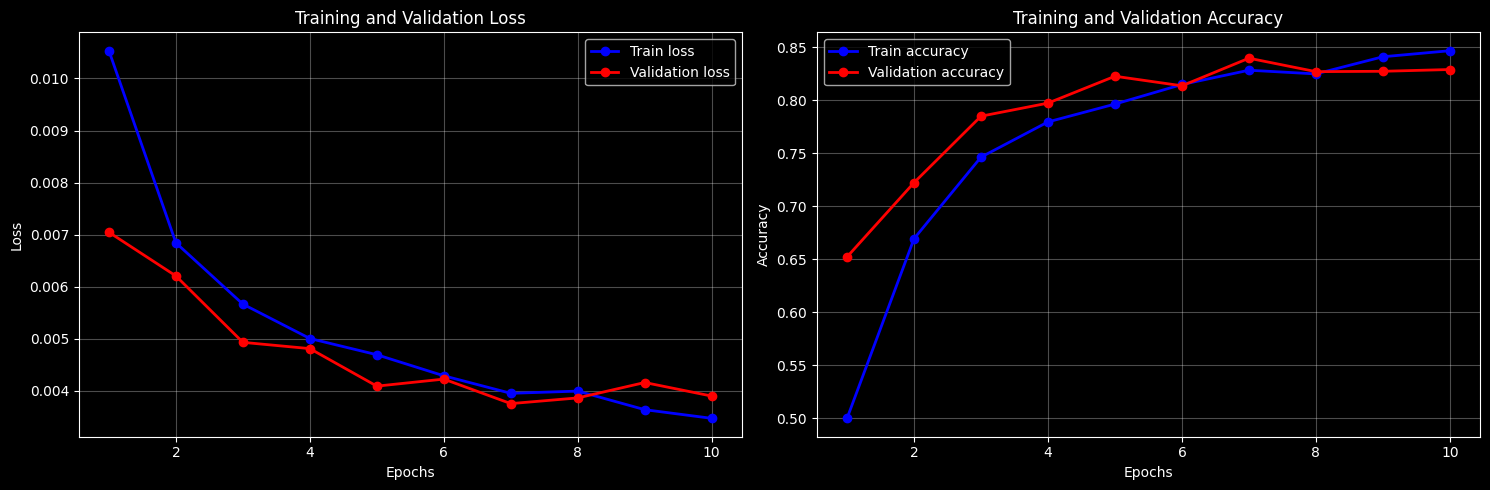

Final results
Best training accuracy: 84.67%
Best validation accuracy: 83.97%
Final train loss: 0.0035
Final validation loss: 0.0039


In [9]:
def plot_training_history(history):
    train_losses, train_accuracies, val_losses, val_accuracies = history
    epochs = range(1, len(train_losses) + 1)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax[0].plot(epochs, train_losses, 'bo-', label='Train loss', lw=2)
    ax[0].plot(epochs, val_losses, 'ro-', label='Validation loss', lw=2)
    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Accuracy plot
    ax[1].plot(epochs, train_accuracies, 'bo-', label='Train accuracy', lw=2)
    ax[1].plot(epochs, val_accuracies, 'ro-', label='Validation accuracy', lw=2)
    ax[1].set_title('Training and Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    best_train_acc = max(train_accuracies)
    best_val_acc = max(val_accuracies)
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]

    print('Final results')
    print(f'Best training accuracy: {best_train_acc*100.:.2f}%')
    print(f'Best validation accuracy: {best_val_acc*100.:.2f}%')
    print(f'Final train loss: {final_train_loss:.4f}')
    print(f'Final validation loss: {final_val_loss:.4f}')

plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.57it/s]


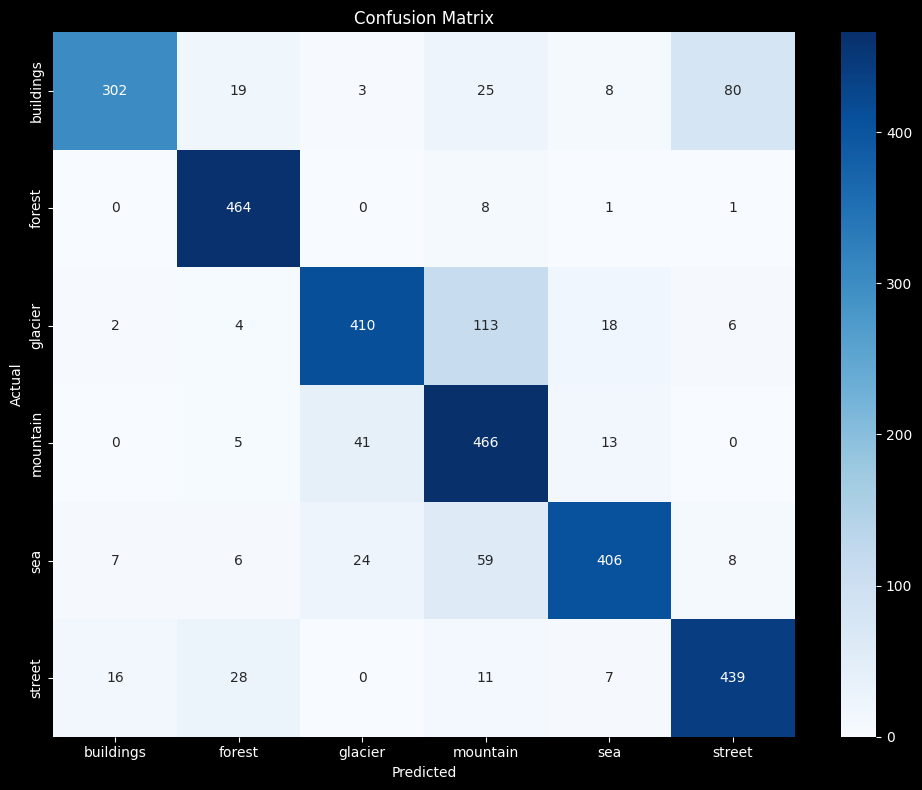


Точность по классам:
buildings: 0.691
forest: 0.979
glacier: 0.741
mountain: 0.888
sea: 0.796
street: 0.876

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.92      0.69      0.79       437
      forest       0.88      0.98      0.93       474
     glacier       0.86      0.74      0.80       553
    mountain       0.68      0.89      0.77       525
         sea       0.90      0.80      0.84       510
      street       0.82      0.88      0.85       501

    accuracy                           0.83      3000
   macro avg       0.84      0.83      0.83      3000
weighted avg       0.84      0.83      0.83      3000



In [10]:
# Детальная оценка на тестовом наборе
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_proba = []
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Evaluation'):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            proba = F.softmax(output, dim=1)
            
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
            y_proba.extend(proba.cpu().numpy())
    
    return np.array(y_true), np.array(y_pred), np.array(y_proba)

y_true, y_pred, y_proba = evaluate_model(model, val_loader)

# Матрица ошибок
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    # Accuracy по классам
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    print("\nТочность по классам:")
    for i, acc in enumerate(class_accuracy):
        print(f"{classes[i]}: {acc:.3f}")

plot_confusion_matrix(y_true, y_pred, classes)

# Отчет по классификации
print("\nДетальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

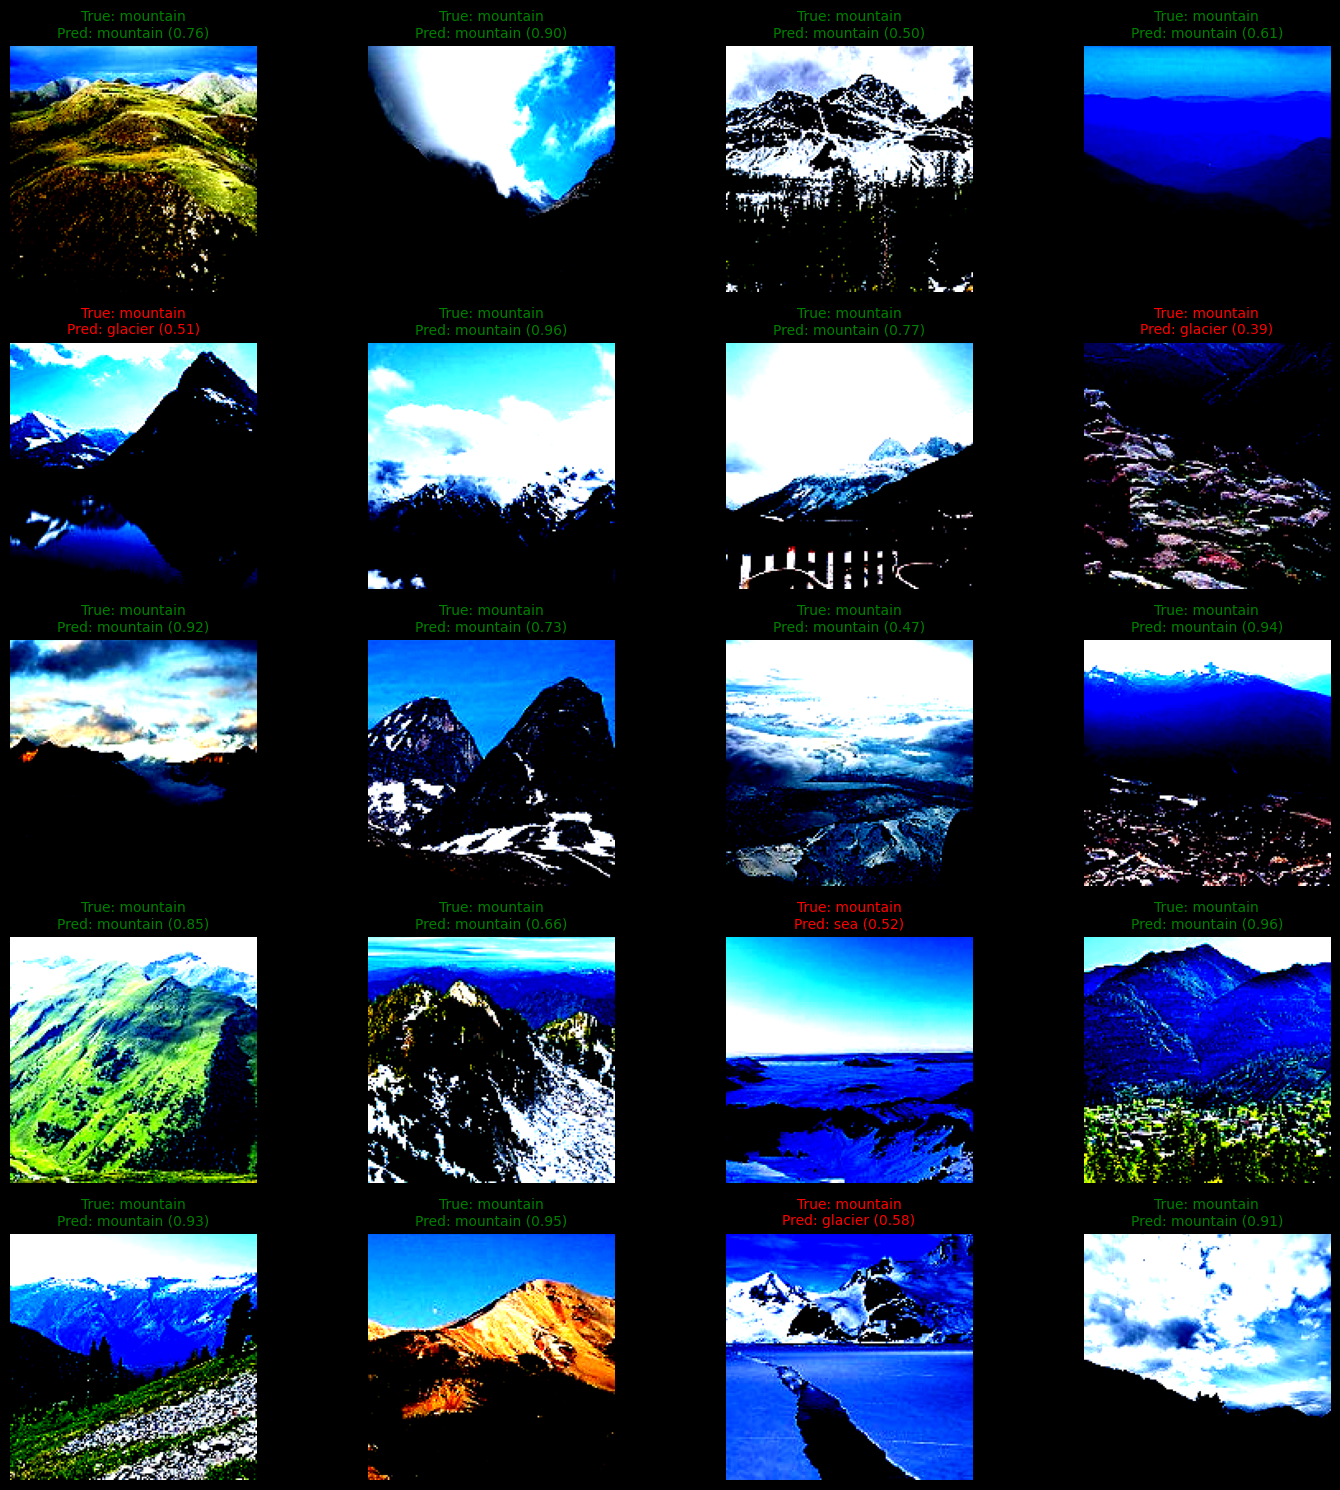

In [11]:
# Визуализация предсказаний
def visualize_predictions(model, test_loader, classes, num_images=20):
    model.eval()
    images_shown = 0
    
    fig, axes = plt.subplots(5, 4, figsize=(15, 15))
    axes = axes.ravel()
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            proba = F.softmax(output, dim=1)
            
            for i in range(data.size(0)):
                if images_shown >= num_images:
                    break
                
                img = data[i].cpu()
                img = torch.clamp(img, 0, 1)
                
                # Отображение
                axes[images_shown].imshow(img.permute(1, 2, 0))
                
                true_label = classes[target[i]]
                pred_label = classes[pred[i]]
                confidence = proba[i][pred[i]].item()
                
                # Цвет: зеленый для правильных, красный для неправильных
                color = 'green' if target[i] == pred[i] else 'red'
                
                axes[images_shown].set_title(
                    f'True: {true_label}\nPred: {pred_label} ({confidence:.2f})',
                    color=color, fontsize=10
                )
                axes[images_shown].axis('off')
                
                images_shown += 1
            
            if images_shown >= num_images:
                break
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_loader, classes)

# Добавление аугментаций

## 1. Базовые геометрические преобразования
* Горизонтальные отражения (horizontal flip)
* Повороты (rotation) ±15°


In [12]:
def run_experiment(model, criterion, optimizer, scheduler, ratio):
    # Training
    train_transform = A.Compose([
        A.Resize(150, 150),
        A.HorizontalFlip(p=ratio),
        A.Rotate(limit=(-15, 15), p=ratio),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    train_dataset = MyDataset(image_paths=train_img_path, 
                              labels=train_img_label, 
                              transform=train_transform)
    train_loader = DataLoader(train_dataset,
                              batch_size=128,
                              shuffle=True,
                              num_workers=0,
                              pin_memory=True)

    # Validation
    val_transform = A.Compose([
        A.Resize(150, 150),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    val_dataset = MyDataset(image_paths=val_img_path, 
                            labels=val_img_label, 
                            transform=val_transform)
    val_loader = DataLoader(val_dataset,
                            batch_size=128,
                            shuffle=False,
                            num_workers=0,
                            pin_memory=True)
    
    # Запуск обучения
    history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)

    return history

### 25% аугментированных данных

In [13]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=0.25)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.57it/s, Loss=0.0070, Acc=67.67%]



Epoch 1/10:
Train Loss: 0.0102, Train Acc: 51.88%
Val Loss: 0.0070, Val Acc: 67.67%
Time: 46.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 67.67%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.84it/s, Loss=0.0086, Acc=63.27%]



Epoch 2/10:
Train Loss: 0.0066, Train Acc: 68.85%
Val Loss: 0.0086, Val Acc: 63.27%
Time: 45.8s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.63it/s, Loss=0.0051, Acc=77.63%]



Epoch 3/10:
Train Loss: 0.0057, Train Acc: 74.46%
Val Loss: 0.0051, Val Acc: 77.63%
Time: 46.3s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 77.63%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.74it/s, Loss=0.0050, Acc=78.30%]



Epoch 4/10:
Train Loss: 0.0051, Train Acc: 77.37%
Val Loss: 0.0050, Val Acc: 78.30%
Time: 45.8s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 78.30%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.79it/s, Loss=0.0042, Acc=81.47%]



Epoch 5/10:
Train Loss: 0.0047, Train Acc: 79.55%
Val Loss: 0.0042, Val Acc: 81.47%
Time: 45.0s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 81.47%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.79it/s, Loss=0.0050, Acc=78.03%]



Epoch 6/10:
Train Loss: 0.0045, Train Acc: 80.71%
Val Loss: 0.0050, Val Acc: 78.03%
Time: 45.9s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.68it/s, Loss=0.0044, Acc=82.03%]



Epoch 7/10:
Train Loss: 0.0043, Train Acc: 81.38%
Val Loss: 0.0044, Val Acc: 82.03%
Time: 47.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 82.03%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.71it/s, Loss=0.0040, Acc=83.23%]



Epoch 8/10:
Train Loss: 0.0040, Train Acc: 82.66%
Val Loss: 0.0040, Val Acc: 83.23%
Time: 46.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 83.23%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.64it/s, Loss=0.0042, Acc=81.73%]



Epoch 9/10:
Train Loss: 0.0038, Train Acc: 84.05%
Val Loss: 0.0042, Val Acc: 81.73%
Time: 46.4s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.62it/s, Loss=0.0034, Acc=85.90%]



Epoch 10/10:
Train Loss: 0.0038, Train Acc: 83.95%
Val Loss: 0.0034, Val Acc: 85.90%
Time: 46.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 85.90%
------------------------------------------------------------

Обучение завершено!
Общее время: 7.7 минут
Лучшая валидационная точность: 85.90%


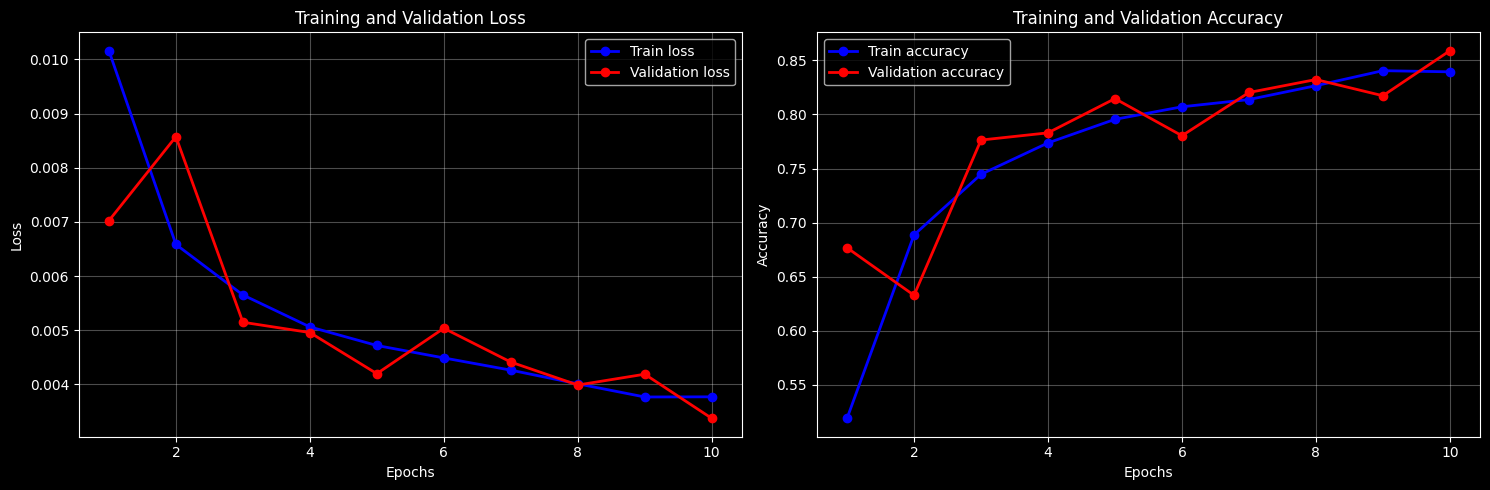

Final results
Best training accuracy: 84.05%
Best validation accuracy: 85.90%
Final train loss: 0.0038
Final validation loss: 0.0034


In [14]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]


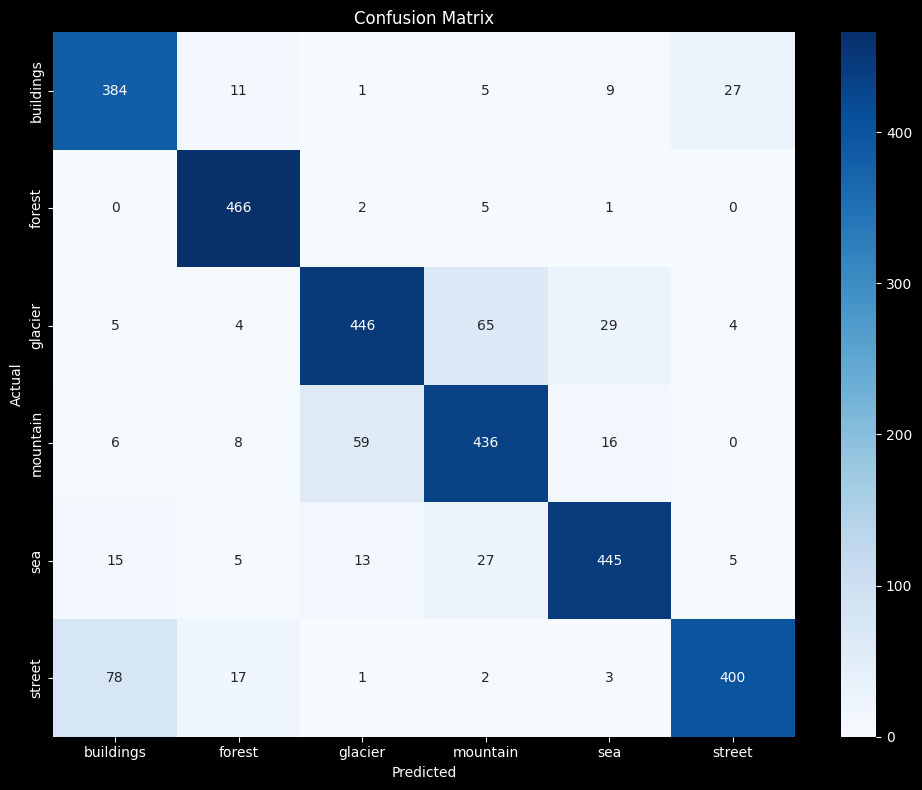


Точность по классам:
buildings: 0.879
forest: 0.983
glacier: 0.807
mountain: 0.830
sea: 0.873
street: 0.798


In [15]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [16]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.79      0.88      0.83       437
      forest       0.91      0.98      0.95       474
     glacier       0.85      0.81      0.83       553
    mountain       0.81      0.83      0.82       525
         sea       0.88      0.87      0.88       510
      street       0.92      0.80      0.85       501

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



### 50% аугментированных данных

In [17]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=0.5)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.66it/s, Loss=0.0091, Acc=58.53%]



Epoch 1/10:
Train Loss: 0.0108, Train Acc: 48.07%
Val Loss: 0.0091, Val Acc: 58.53%
Time: 48.6s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 58.53%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.83it/s, Loss=0.0059, Acc=73.33%]



Epoch 2/10:
Train Loss: 0.0072, Train Acc: 65.27%
Val Loss: 0.0059, Val Acc: 73.33%
Time: 48.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 73.33%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.73it/s, Loss=0.0054, Acc=74.67%]



Epoch 3/10:
Train Loss: 0.0060, Train Acc: 72.38%
Val Loss: 0.0054, Val Acc: 74.67%
Time: 48.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 74.67%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.71it/s, Loss=0.0045, Acc=81.03%]



Epoch 4/10:
Train Loss: 0.0053, Train Acc: 76.40%
Val Loss: 0.0045, Val Acc: 81.03%
Time: 48.0s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 81.03%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.59it/s, Loss=0.0039, Acc=83.10%]



Epoch 5/10:
Train Loss: 0.0052, Train Acc: 77.21%
Val Loss: 0.0039, Val Acc: 83.10%
Time: 48.0s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 83.10%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.59it/s, Loss=0.0041, Acc=82.47%]



Epoch 6/10:
Train Loss: 0.0047, Train Acc: 79.34%
Val Loss: 0.0041, Val Acc: 82.47%
Time: 48.6s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.69it/s, Loss=0.0037, Acc=84.60%]



Epoch 7/10:
Train Loss: 0.0045, Train Acc: 80.33%
Val Loss: 0.0037, Val Acc: 84.60%
Time: 48.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 84.60%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.64it/s, Loss=0.0037, Acc=84.77%]



Epoch 8/10:
Train Loss: 0.0044, Train Acc: 81.30%
Val Loss: 0.0037, Val Acc: 84.77%
Time: 49.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 84.77%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.62it/s, Loss=0.0037, Acc=84.87%]



Epoch 9/10:
Train Loss: 0.0041, Train Acc: 82.14%
Val Loss: 0.0037, Val Acc: 84.87%
Time: 47.6s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 84.87%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.74it/s, Loss=0.0045, Acc=79.97%]


Epoch 10/10:
Train Loss: 0.0041, Train Acc: 82.71%
Val Loss: 0.0045, Val Acc: 79.97%
Time: 47.7s, LR: 0.001000
------------------------------------------------------------

Обучение завершено!
Общее время: 8.1 минут
Лучшая валидационная точность: 84.87%


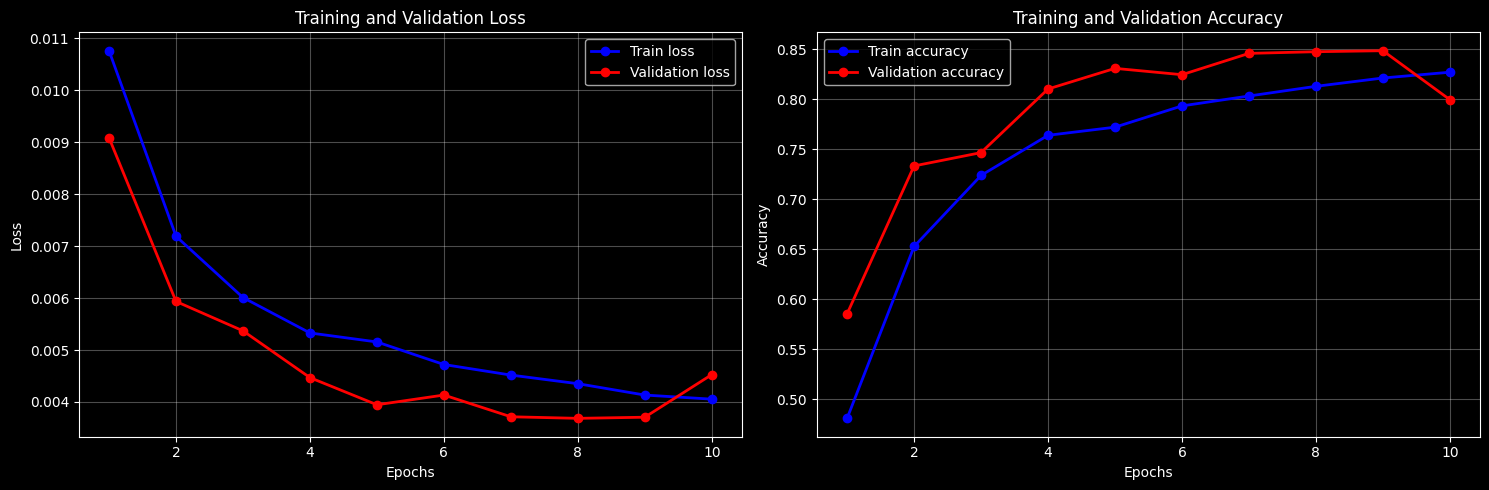

Final results
Best training accuracy: 82.71%
Best validation accuracy: 84.87%
Final train loss: 0.0041
Final validation loss: 0.0045


In [18]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.65it/s]


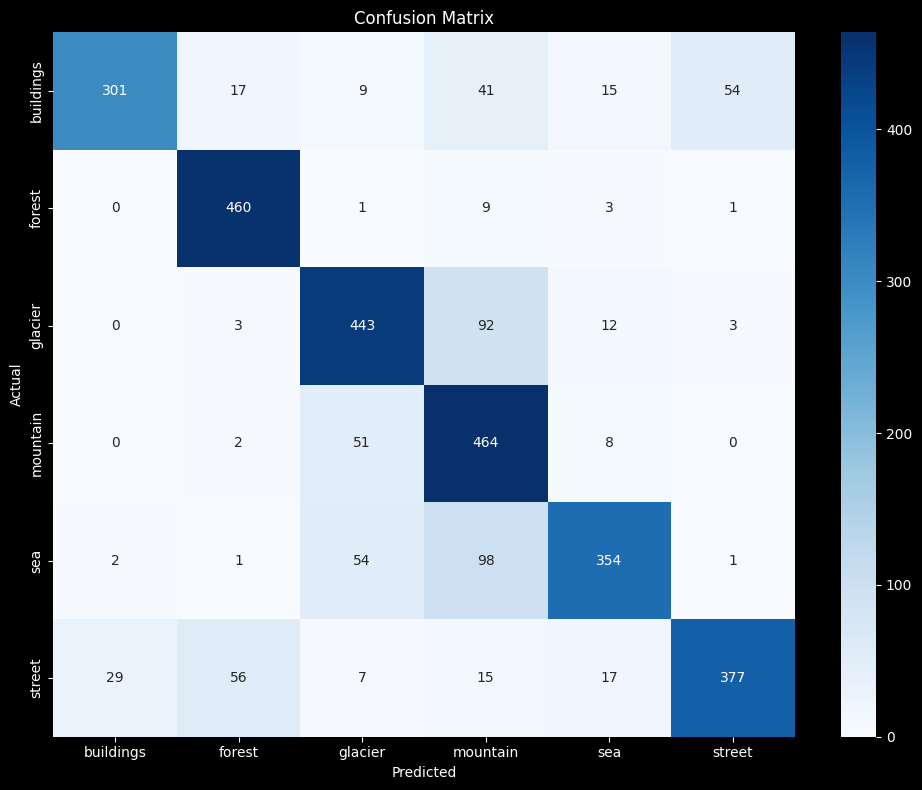


Точность по классам:
buildings: 0.689
forest: 0.970
glacier: 0.801
mountain: 0.884
sea: 0.694
street: 0.752


In [19]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [20]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.91      0.69      0.78       437
      forest       0.85      0.97      0.91       474
     glacier       0.78      0.80      0.79       553
    mountain       0.65      0.88      0.75       525
         sea       0.87      0.69      0.77       510
      street       0.86      0.75      0.80       501

    accuracy                           0.80      3000
   macro avg       0.82      0.80      0.80      3000
weighted avg       0.82      0.80      0.80      3000



### 75% аугментированных данных

In [21]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=0.75)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.68it/s, Loss=0.0088, Acc=58.40%]



Epoch 1/10:
Train Loss: 0.0110, Train Acc: 47.78%
Val Loss: 0.0088, Val Acc: 58.40%
Time: 49.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 58.40%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.67it/s, Loss=0.0068, Acc=67.47%]



Epoch 2/10:
Train Loss: 0.0073, Train Acc: 65.58%
Val Loss: 0.0068, Val Acc: 67.47%
Time: 49.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 67.47%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.85it/s, Loss=0.0053, Acc=77.20%]



Epoch 3/10:
Train Loss: 0.0063, Train Acc: 71.51%
Val Loss: 0.0053, Val Acc: 77.20%
Time: 49.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 77.20%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.63it/s, Loss=0.0053, Acc=76.33%]



Epoch 4/10:
Train Loss: 0.0056, Train Acc: 75.02%
Val Loss: 0.0053, Val Acc: 76.33%
Time: 50.1s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s, Loss=0.0047, Acc=78.70%]



Epoch 5/10:
Train Loss: 0.0052, Train Acc: 77.50%
Val Loss: 0.0047, Val Acc: 78.70%
Time: 49.6s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 78.70%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.60it/s, Loss=0.0046, Acc=80.27%]



Epoch 6/10:
Train Loss: 0.0048, Train Acc: 79.45%
Val Loss: 0.0046, Val Acc: 80.27%
Time: 51.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 80.27%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.62it/s, Loss=0.0055, Acc=79.50%]



Epoch 7/10:
Train Loss: 0.0046, Train Acc: 80.24%
Val Loss: 0.0055, Val Acc: 79.50%
Time: 48.8s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.61it/s, Loss=0.0036, Acc=85.20%]



Epoch 8/10:
Train Loss: 0.0045, Train Acc: 80.45%
Val Loss: 0.0036, Val Acc: 85.20%
Time: 49.2s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 85.20%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.84it/s, Loss=0.0041, Acc=83.50%]



Epoch 9/10:
Train Loss: 0.0042, Train Acc: 81.87%
Val Loss: 0.0041, Val Acc: 83.50%
Time: 49.3s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.71it/s, Loss=0.0039, Acc=82.43%]


Epoch 10/10:
Train Loss: 0.0040, Train Acc: 82.34%
Val Loss: 0.0039, Val Acc: 82.43%
Time: 48.3s, LR: 0.001000
------------------------------------------------------------

Обучение завершено!
Общее время: 8.3 минут
Лучшая валидационная точность: 85.20%


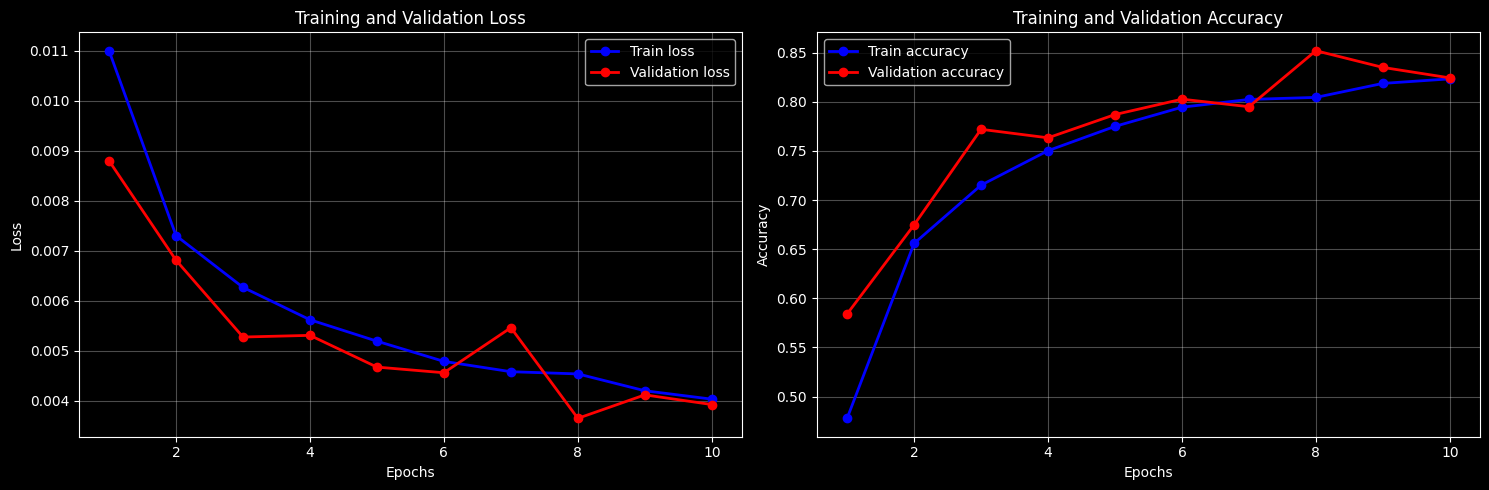

Final results
Best training accuracy: 82.34%
Best validation accuracy: 85.20%
Final train loss: 0.0040
Final validation loss: 0.0039


In [22]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.83it/s]


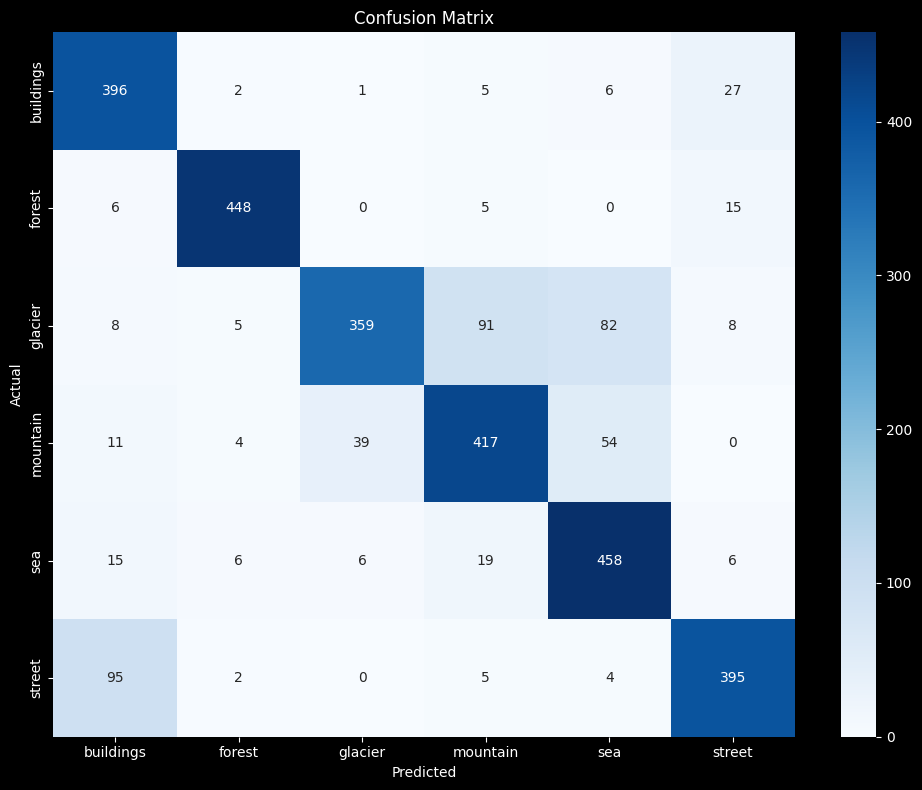


Точность по классам:
buildings: 0.906
forest: 0.945
glacier: 0.649
mountain: 0.794
sea: 0.898
street: 0.788


In [23]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [24]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.75      0.91      0.82       437
      forest       0.96      0.95      0.95       474
     glacier       0.89      0.65      0.75       553
    mountain       0.77      0.79      0.78       525
         sea       0.76      0.90      0.82       510
      street       0.88      0.79      0.83       501

    accuracy                           0.82      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.82      0.82      3000



### 100% аугментированных данных

In [25]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=1.0)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.78it/s, Loss=0.0072, Acc=64.10%]



Epoch 1/10:
Train Loss: 0.0108, Train Acc: 48.65%
Val Loss: 0.0072, Val Acc: 64.10%
Time: 50.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 64.10%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.65it/s, Loss=0.0064, Acc=69.33%]



Epoch 2/10:
Train Loss: 0.0077, Train Acc: 61.78%
Val Loss: 0.0064, Val Acc: 69.33%
Time: 50.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 69.33%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:07<00:00,  3.32it/s, Loss=0.0071, Acc=67.83%]



Epoch 3/10:
Train Loss: 0.0066, Train Acc: 68.04%
Val Loss: 0.0071, Val Acc: 67.83%
Time: 51.3s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.66it/s, Loss=0.0074, Acc=70.23%]



Epoch 4/10:
Train Loss: 0.0059, Train Acc: 73.09%
Val Loss: 0.0074, Val Acc: 70.23%
Time: 54.6s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 70.23%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.65it/s, Loss=0.0057, Acc=75.50%]



Epoch 5/10:
Train Loss: 0.0054, Train Acc: 76.04%
Val Loss: 0.0057, Val Acc: 75.50%
Time: 50.2s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 75.50%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.85it/s, Loss=0.0053, Acc=78.73%]



Epoch 6/10:
Train Loss: 0.0050, Train Acc: 78.23%
Val Loss: 0.0053, Val Acc: 78.73%
Time: 50.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 78.73%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.89it/s, Loss=0.0045, Acc=79.73%]



Epoch 7/10:
Train Loss: 0.0047, Train Acc: 79.31%
Val Loss: 0.0045, Val Acc: 79.73%
Time: 52.6s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 79.73%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.64it/s, Loss=0.0047, Acc=81.07%]



Epoch 8/10:
Train Loss: 0.0045, Train Acc: 80.69%
Val Loss: 0.0047, Val Acc: 81.07%
Time: 51.2s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 81.07%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.67it/s, Loss=0.0038, Acc=83.40%]



Epoch 9/10:
Train Loss: 0.0043, Train Acc: 81.32%
Val Loss: 0.0038, Val Acc: 83.40%
Time: 50.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 83.40%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.65it/s, Loss=0.0040, Acc=82.70%]


Epoch 10/10:
Train Loss: 0.0041, Train Acc: 81.72%
Val Loss: 0.0040, Val Acc: 82.70%
Time: 51.3s, LR: 0.001000
------------------------------------------------------------

Обучение завершено!
Общее время: 8.6 минут
Лучшая валидационная точность: 83.40%


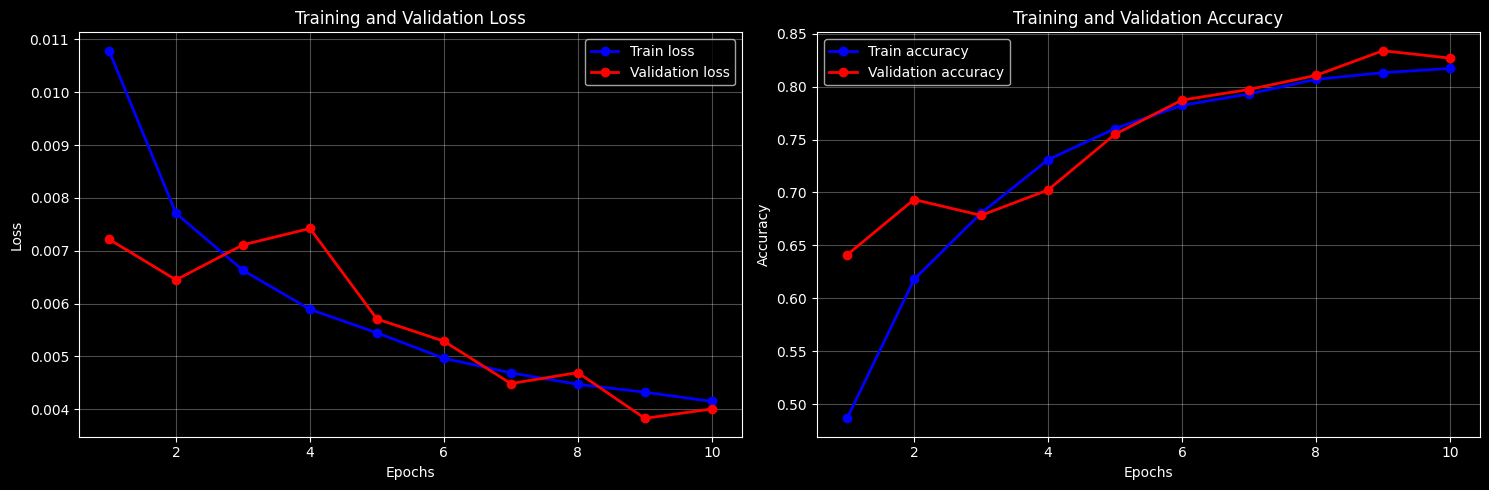

Final results
Best training accuracy: 81.72%
Best validation accuracy: 83.40%
Final train loss: 0.0041
Final validation loss: 0.0040


In [26]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.63it/s]


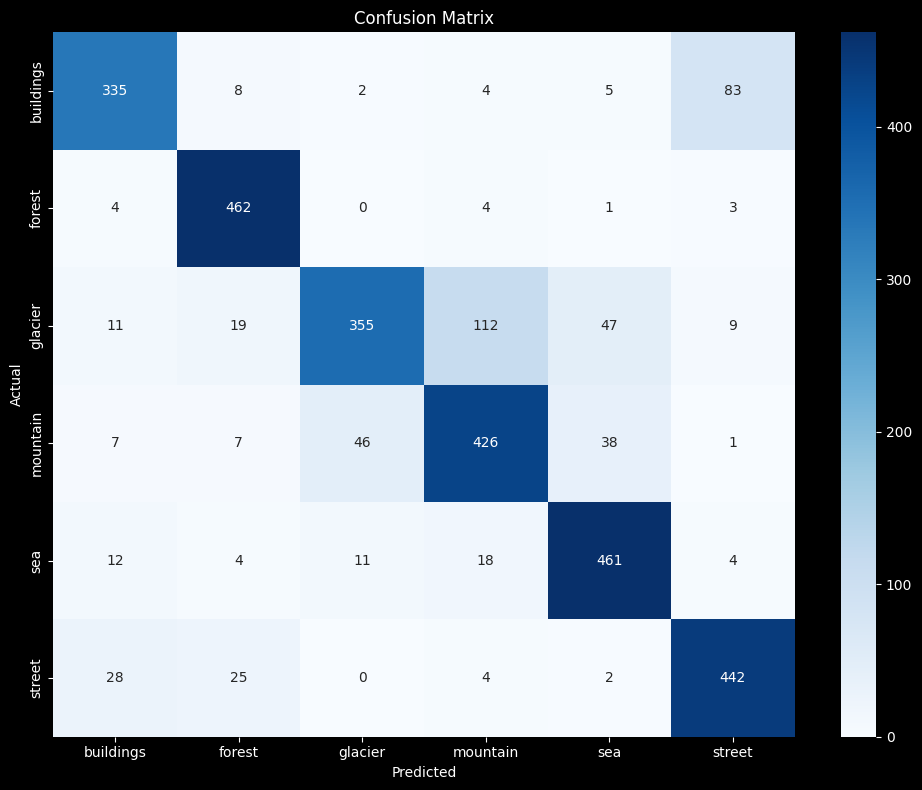


Точность по классам:
buildings: 0.767
forest: 0.975
glacier: 0.642
mountain: 0.811
sea: 0.904
street: 0.882


In [27]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [28]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.84      0.77      0.80       437
      forest       0.88      0.97      0.92       474
     glacier       0.86      0.64      0.73       553
    mountain       0.75      0.81      0.78       525
         sea       0.83      0.90      0.87       510
      street       0.82      0.88      0.85       501

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.82      3000



## 2. Добавление искажений
* Предыдущие аугментации +
* Случайный зум (random zoom) ±10%
* Сдвиги (translation) ±10%

In [31]:
def run_experiment(model, criterion, optimizer, scheduler, ratio):
    # Training
    train_transform = A.Compose([
        A.HorizontalFlip(p=ratio),
        A.Rotate(limit=(-15, 15), p=ratio),
        A.RandomScale(scale_limit=(0.9, 1.1), p=ratio),
        A.ShiftScaleRotate(shift_limit=(0.1, 0.1), scale_limit=0, 
                           rotate_limit=0, border_mode=cv2.BORDER_REFLECT, p=ratio),
        A.Resize(150, 150),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    train_dataset = MyDataset(image_paths=train_img_path, 
                              labels=train_img_label, 
                              transform=train_transform)
    train_loader = DataLoader(train_dataset,
                              batch_size=128,
                              shuffle=True,
                              num_workers=0,
                              pin_memory=True)

    # Validation
    val_transform = A.Compose([
        A.Resize(150, 150),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    val_dataset = MyDataset(image_paths=val_img_path, 
                            labels=val_img_label, 
                            transform=val_transform)
    val_loader = DataLoader(val_dataset,
                            batch_size=128,
                            shuffle=False,
                            num_workers=0,
                            pin_memory=True)
    
    # Запуск обучения
    history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)

    return history

### 25% аугментированных данных

In [32]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=0.25)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.80it/s, Loss=0.0069, Acc=67.30%]



Epoch 1/10:
Train Loss: 0.0106, Train Acc: 49.69%
Val Loss: 0.0069, Val Acc: 67.30%
Time: 50.6s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 67.30%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.86it/s, Loss=0.0071, Acc=68.43%]



Epoch 2/10:
Train Loss: 0.0073, Train Acc: 65.13%
Val Loss: 0.0071, Val Acc: 68.43%
Time: 49.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 68.43%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:07<00:00,  3.38it/s, Loss=0.0055, Acc=76.87%]



Epoch 3/10:
Train Loss: 0.0060, Train Acc: 73.07%
Val Loss: 0.0055, Val Acc: 76.87%
Time: 51.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 76.87%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:07<00:00,  3.03it/s, Loss=0.0042, Acc=82.93%]



Epoch 4/10:
Train Loss: 0.0053, Train Acc: 76.76%
Val Loss: 0.0042, Val Acc: 82.93%
Time: 53.2s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 82.93%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.69it/s, Loss=0.0046, Acc=81.43%]



Epoch 5/10:
Train Loss: 0.0050, Train Acc: 77.92%
Val Loss: 0.0046, Val Acc: 81.43%
Time: 50.9s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.71it/s, Loss=0.0056, Acc=75.53%]



Epoch 6/10:
Train Loss: 0.0046, Train Acc: 80.28%
Val Loss: 0.0056, Val Acc: 75.53%
Time: 48.3s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.85it/s, Loss=0.0038, Acc=83.27%]



Epoch 7/10:
Train Loss: 0.0044, Train Acc: 80.65%
Val Loss: 0.0038, Val Acc: 83.27%
Time: 58.8s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 83.27%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.86it/s, Loss=0.0038, Acc=84.23%]



Epoch 8/10:
Train Loss: 0.0042, Train Acc: 81.64%
Val Loss: 0.0038, Val Acc: 84.23%
Time: 61.3s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 84.23%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s, Loss=0.0102, Acc=69.00%]



Epoch 9/10:
Train Loss: 0.0041, Train Acc: 81.95%
Val Loss: 0.0102, Val Acc: 69.00%
Time: 61.2s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.84it/s, Loss=0.0049, Acc=78.73%]


Epoch 10/10:
Train Loss: 0.0040, Train Acc: 82.52%
Val Loss: 0.0049, Val Acc: 78.73%
Time: 60.4s, LR: 0.001000
------------------------------------------------------------

Обучение завершено!
Общее время: 9.1 минут
Лучшая валидационная точность: 84.23%


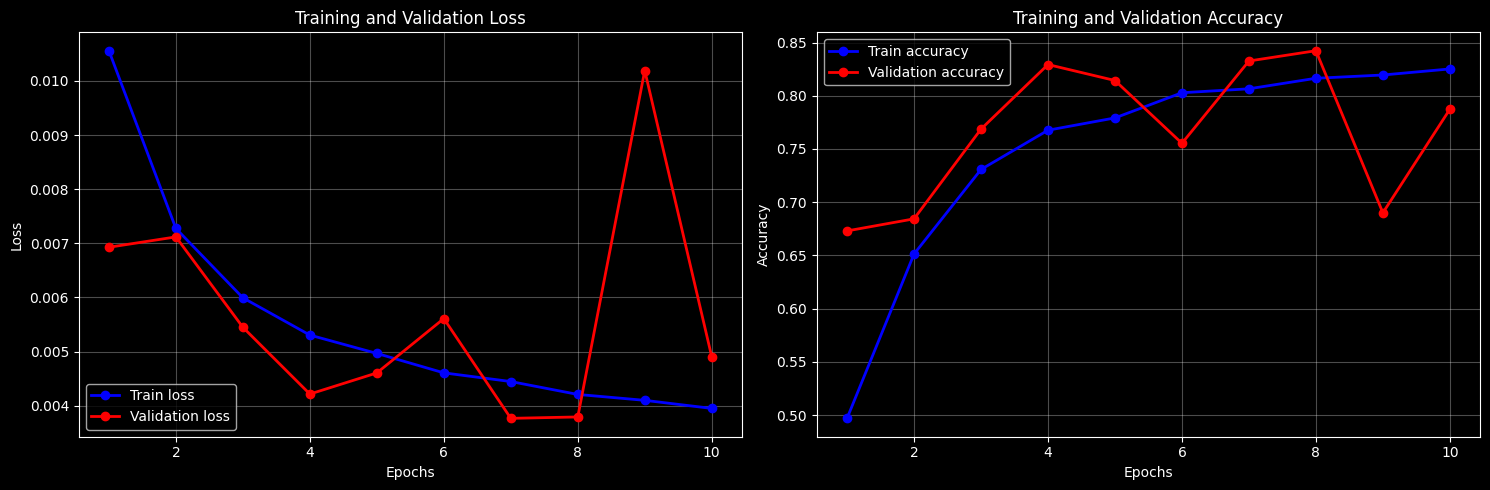

Final results
Best training accuracy: 82.52%
Best validation accuracy: 84.23%
Final train loss: 0.0040
Final validation loss: 0.0049


In [33]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.69it/s]


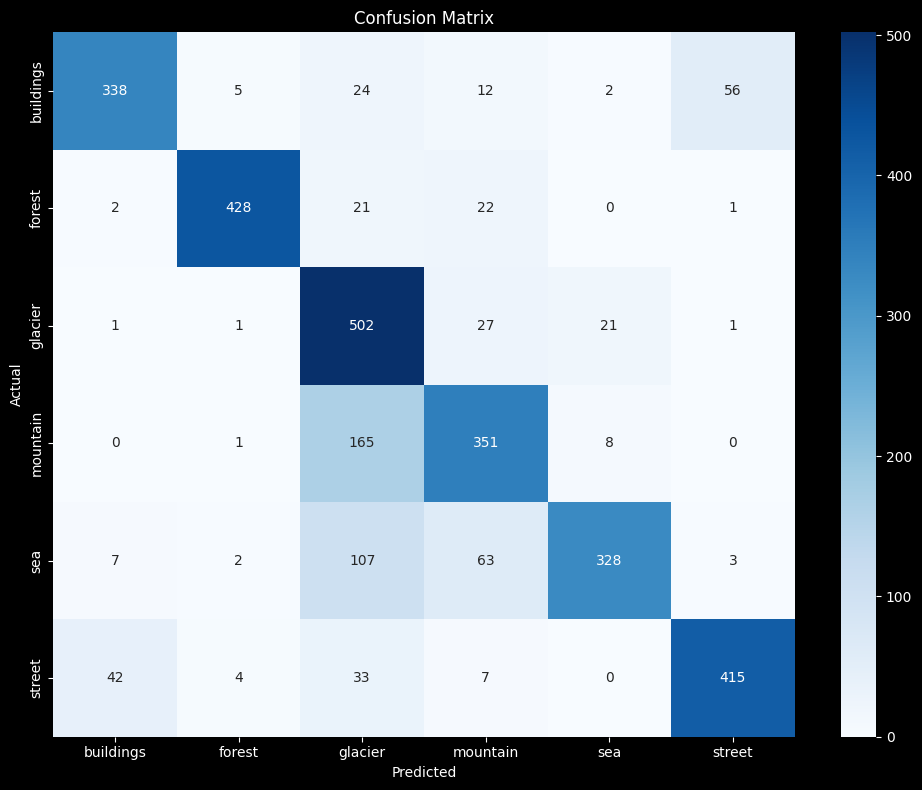


Точность по классам:
buildings: 0.773
forest: 0.903
glacier: 0.908
mountain: 0.669
sea: 0.643
street: 0.828


In [34]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [35]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.87      0.77      0.82       437
      forest       0.97      0.90      0.94       474
     glacier       0.59      0.91      0.71       553
    mountain       0.73      0.67      0.70       525
         sea       0.91      0.64      0.75       510
      street       0.87      0.83      0.85       501

    accuracy                           0.79      3000
   macro avg       0.82      0.79      0.79      3000
weighted avg       0.82      0.79      0.79      3000



### 50% аугментированных данных

In [36]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=0.5)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.73it/s, Loss=0.0076, Acc=65.37%]



Epoch 1/10:
Train Loss: 0.0107, Train Acc: 48.37%
Val Loss: 0.0076, Val Acc: 65.37%
Time: 58.3s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 65.37%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.87it/s, Loss=0.0060, Acc=72.43%]



Epoch 2/10:
Train Loss: 0.0074, Train Acc: 63.71%
Val Loss: 0.0060, Val Acc: 72.43%
Time: 55.8s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 72.43%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.91it/s, Loss=0.0056, Acc=73.93%]



Epoch 3/10:
Train Loss: 0.0065, Train Acc: 69.84%
Val Loss: 0.0056, Val Acc: 73.93%
Time: 55.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 73.93%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.98it/s, Loss=0.0058, Acc=74.30%]



Epoch 4/10:
Train Loss: 0.0057, Train Acc: 74.63%
Val Loss: 0.0058, Val Acc: 74.30%
Time: 55.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 74.30%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.83it/s, Loss=0.0066, Acc=72.87%]



Epoch 5/10:
Train Loss: 0.0053, Train Acc: 76.90%
Val Loss: 0.0066, Val Acc: 72.87%
Time: 56.3s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.76it/s, Loss=0.0049, Acc=79.13%]



Epoch 6/10:
Train Loss: 0.0050, Train Acc: 78.00%
Val Loss: 0.0049, Val Acc: 79.13%
Time: 56.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 79.13%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.76it/s, Loss=0.0042, Acc=82.73%]



Epoch 7/10:
Train Loss: 0.0046, Train Acc: 80.22%
Val Loss: 0.0042, Val Acc: 82.73%
Time: 55.0s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 82.73%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.76it/s, Loss=0.0053, Acc=76.93%]



Epoch 8/10:
Train Loss: 0.0046, Train Acc: 79.90%
Val Loss: 0.0053, Val Acc: 76.93%
Time: 55.7s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.50it/s, Loss=0.0035, Acc=85.33%]



Epoch 9/10:
Train Loss: 0.0044, Train Acc: 80.95%
Val Loss: 0.0035, Val Acc: 85.33%
Time: 58.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 85.33%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.59it/s, Loss=0.0064, Acc=74.30%]


Epoch 10/10:
Train Loss: 0.0042, Train Acc: 81.32%
Val Loss: 0.0064, Val Acc: 74.30%
Time: 55.7s, LR: 0.001000
------------------------------------------------------------

Обучение завершено!
Общее время: 9.4 минут
Лучшая валидационная точность: 85.33%


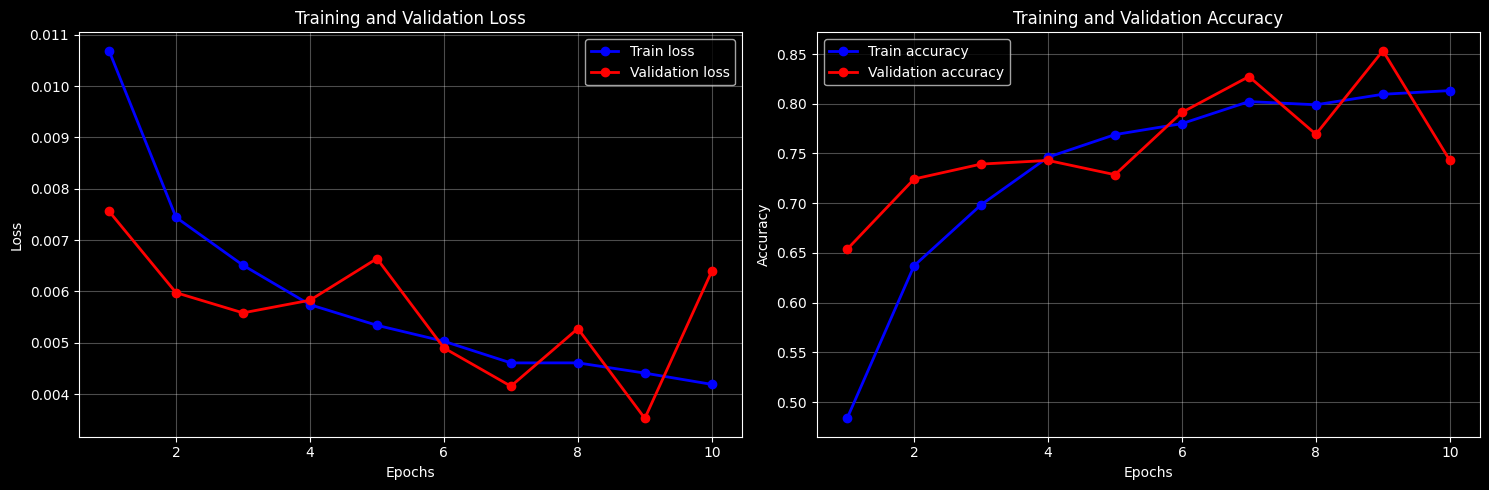

Final results
Best training accuracy: 81.32%
Best validation accuracy: 85.33%
Final train loss: 0.0042
Final validation loss: 0.0064


In [37]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.77it/s]


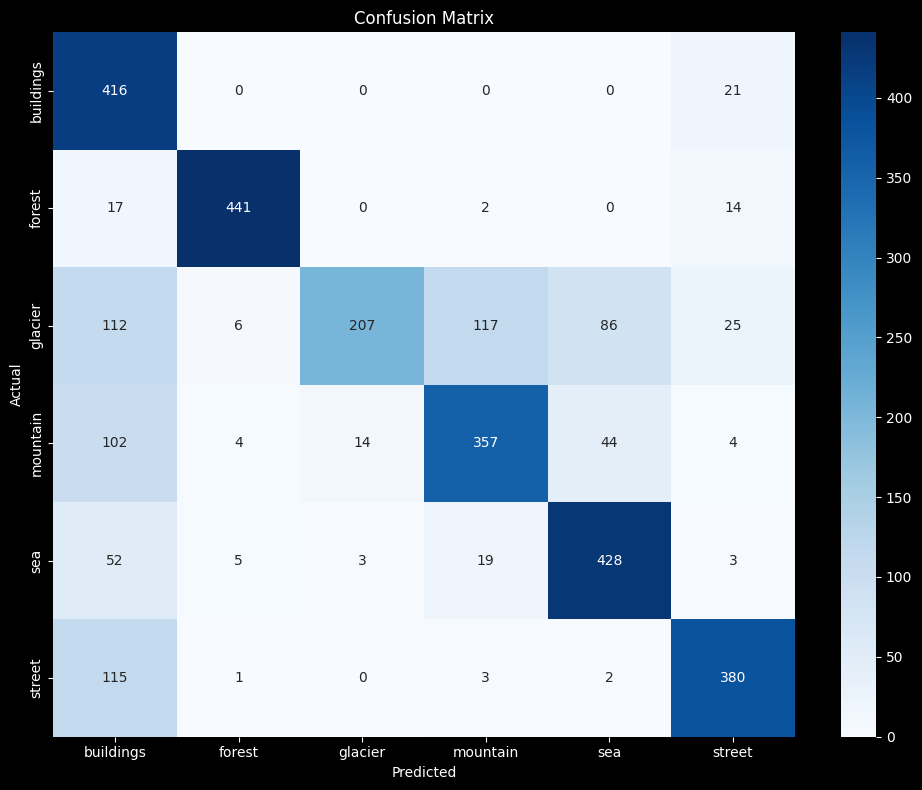


Точность по классам:
buildings: 0.952
forest: 0.930
glacier: 0.374
mountain: 0.680
sea: 0.839
street: 0.758


In [38]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [39]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.51      0.95      0.67       437
      forest       0.96      0.93      0.95       474
     glacier       0.92      0.37      0.53       553
    mountain       0.72      0.68      0.70       525
         sea       0.76      0.84      0.80       510
      street       0.85      0.76      0.80       501

    accuracy                           0.74      3000
   macro avg       0.79      0.76      0.74      3000
weighted avg       0.79      0.74      0.74      3000



### 75% аугментированных данных

In [40]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=0.75)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.85it/s, Loss=0.0078, Acc=63.80%]



Epoch 1/10:
Train Loss: 0.0105, Train Acc: 49.24%
Val Loss: 0.0078, Val Acc: 63.80%
Time: 63.3s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 63.80%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.69it/s, Loss=0.0066, Acc=73.20%]



Epoch 2/10:
Train Loss: 0.0079, Train Acc: 61.29%
Val Loss: 0.0066, Val Acc: 73.20%
Time: 63.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 73.20%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.94it/s, Loss=0.0082, Acc=66.13%]



Epoch 3/10:
Train Loss: 0.0067, Train Acc: 68.84%
Val Loss: 0.0082, Val Acc: 66.13%
Time: 63.8s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.95it/s, Loss=0.0062, Acc=70.33%]



Epoch 4/10:
Train Loss: 0.0060, Train Acc: 73.46%
Val Loss: 0.0062, Val Acc: 70.33%
Time: 62.5s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  4.00it/s, Loss=0.0069, Acc=71.07%]



Epoch 5/10:
Train Loss: 0.0055, Train Acc: 75.62%
Val Loss: 0.0069, Val Acc: 71.07%
Time: 62.7s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s, Loss=0.0066, Acc=73.83%]



Epoch 6/10:
Train Loss: 0.0051, Train Acc: 77.33%
Val Loss: 0.0066, Val Acc: 73.83%
Time: 63.2s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 73.83%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s, Loss=0.0087, Acc=65.17%]



Epoch 7/10:
Train Loss: 0.0048, Train Acc: 79.35%
Val Loss: 0.0087, Val Acc: 65.17%
Time: 62.8s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.07it/s, Loss=0.0052, Acc=78.47%]



Epoch 8/10:
Train Loss: 0.0046, Train Acc: 80.05%
Val Loss: 0.0052, Val Acc: 78.47%
Time: 63.2s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 78.47%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.74it/s, Loss=0.0047, Acc=78.47%]



Epoch 9/10:
Train Loss: 0.0045, Train Acc: 80.38%
Val Loss: 0.0047, Val Acc: 78.47%
Time: 63.1s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.73it/s, Loss=0.0040, Acc=83.07%]



Epoch 10/10:
Train Loss: 0.0044, Train Acc: 80.85%
Val Loss: 0.0040, Val Acc: 83.07%
Time: 63.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 83.07%
------------------------------------------------------------

Обучение завершено!
Общее время: 10.5 минут
Лучшая валидационная точность: 83.07%


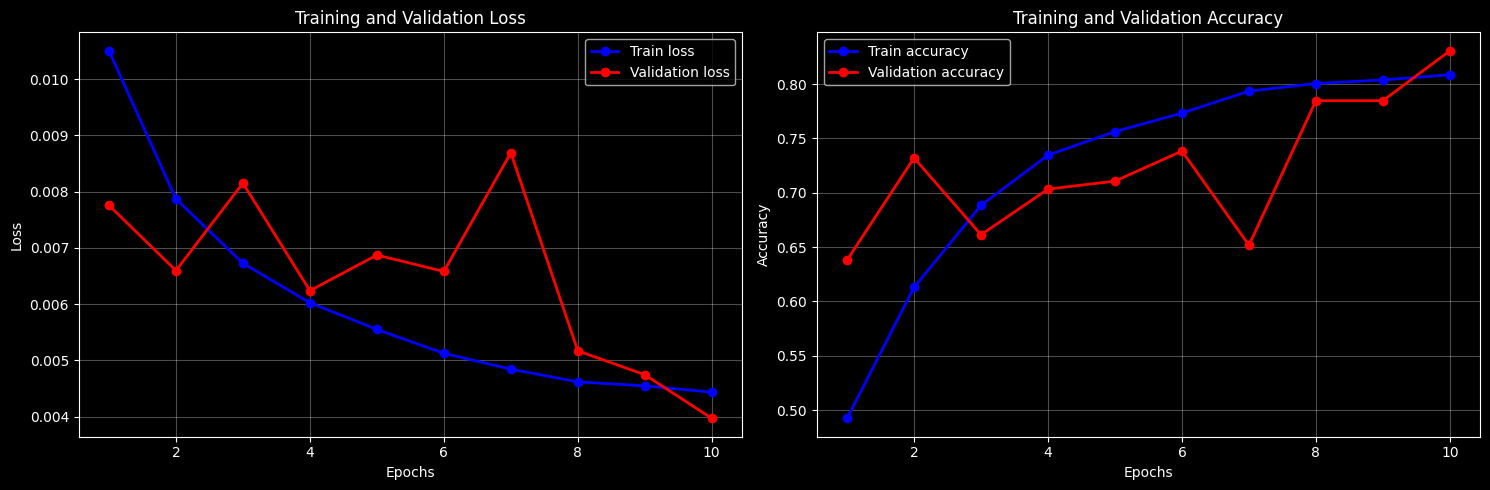

Final results
Best training accuracy: 80.85%
Best validation accuracy: 83.07%
Final train loss: 0.0044
Final validation loss: 0.0040


In [41]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.70it/s]


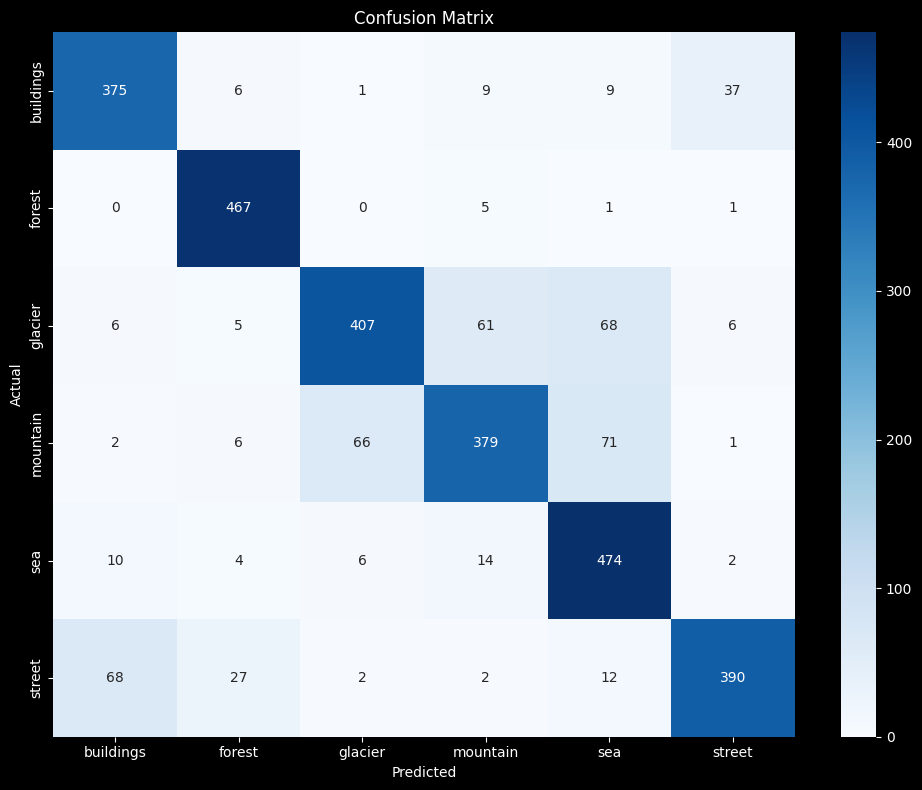


Точность по классам:
buildings: 0.858
forest: 0.985
glacier: 0.736
mountain: 0.722
sea: 0.929
street: 0.778


In [42]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [43]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.81      0.86      0.84       437
      forest       0.91      0.99      0.94       474
     glacier       0.84      0.74      0.79       553
    mountain       0.81      0.72      0.76       525
         sea       0.75      0.93      0.83       510
      street       0.89      0.78      0.83       501

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



### 100% аугментированных данных

In [44]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=1.0)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.76it/s, Loss=0.0076, Acc=63.87%]



Epoch 1/10:
Train Loss: 0.0106, Train Acc: 46.69%
Val Loss: 0.0076, Val Acc: 63.87%
Time: 74.0s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 63.87%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.85it/s, Loss=0.0073, Acc=64.77%]



Epoch 2/10:
Train Loss: 0.0078, Train Acc: 61.29%
Val Loss: 0.0073, Val Acc: 64.77%
Time: 72.8s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 64.77%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s, Loss=0.0074, Acc=66.40%]



Epoch 3/10:
Train Loss: 0.0066, Train Acc: 69.39%
Val Loss: 0.0074, Val Acc: 66.40%
Time: 72.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 66.40%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.72it/s, Loss=0.0052, Acc=77.60%]



Epoch 4/10:
Train Loss: 0.0058, Train Acc: 73.85%
Val Loss: 0.0052, Val Acc: 77.60%
Time: 73.6s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 77.60%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.88it/s, Loss=0.0058, Acc=74.80%]



Epoch 5/10:
Train Loss: 0.0055, Train Acc: 75.70%
Val Loss: 0.0058, Val Acc: 74.80%
Time: 72.4s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.94it/s, Loss=0.0052, Acc=76.63%]



Epoch 6/10:
Train Loss: 0.0051, Train Acc: 77.54%
Val Loss: 0.0052, Val Acc: 76.63%
Time: 72.1s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.97it/s, Loss=0.0099, Acc=64.33%]



Epoch 7/10:
Train Loss: 0.0048, Train Acc: 79.13%
Val Loss: 0.0099, Val Acc: 64.33%
Time: 72.2s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.93it/s, Loss=0.0044, Acc=80.77%]



Epoch 8/10:
Train Loss: 0.0047, Train Acc: 79.44%
Val Loss: 0.0044, Val Acc: 80.77%
Time: 72.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 80.77%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.83it/s, Loss=0.0046, Acc=78.67%]



Epoch 9/10:
Train Loss: 0.0045, Train Acc: 81.03%
Val Loss: 0.0046, Val Acc: 78.67%
Time: 72.2s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.80it/s, Loss=0.0054, Acc=78.23%]


Epoch 10/10:
Train Loss: 0.0043, Train Acc: 80.94%
Val Loss: 0.0054, Val Acc: 78.23%
Time: 72.7s, LR: 0.001000
------------------------------------------------------------

Обучение завершено!
Общее время: 12.1 минут
Лучшая валидационная точность: 80.77%


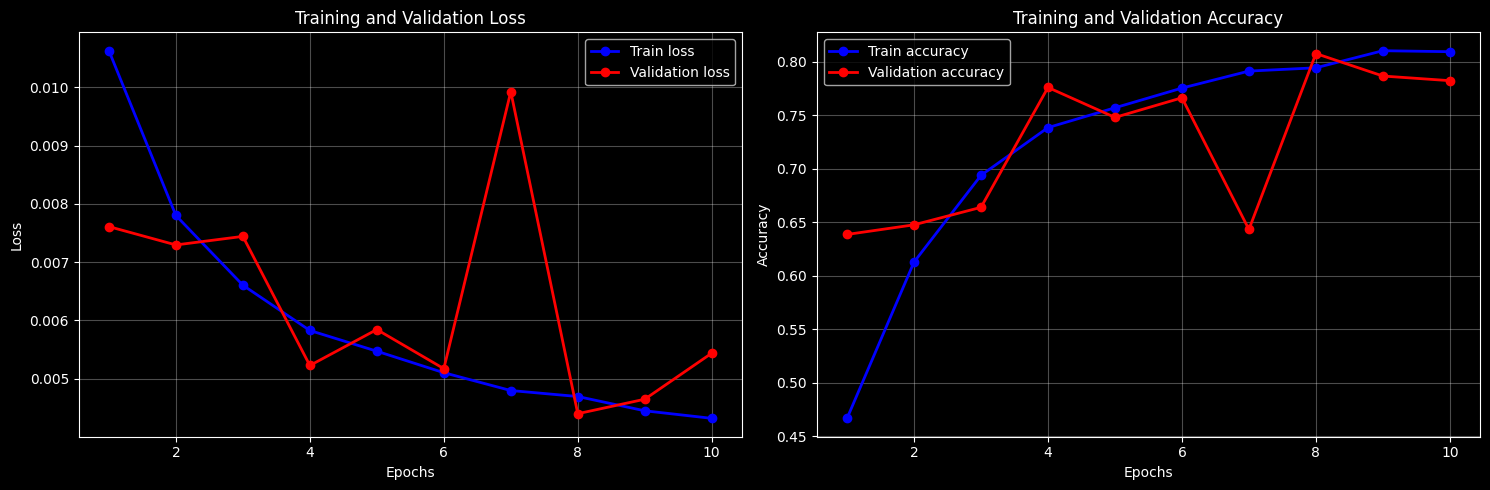

Final results
Best training accuracy: 81.03%
Best validation accuracy: 80.77%
Final train loss: 0.0043
Final validation loss: 0.0054


In [45]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.87it/s]


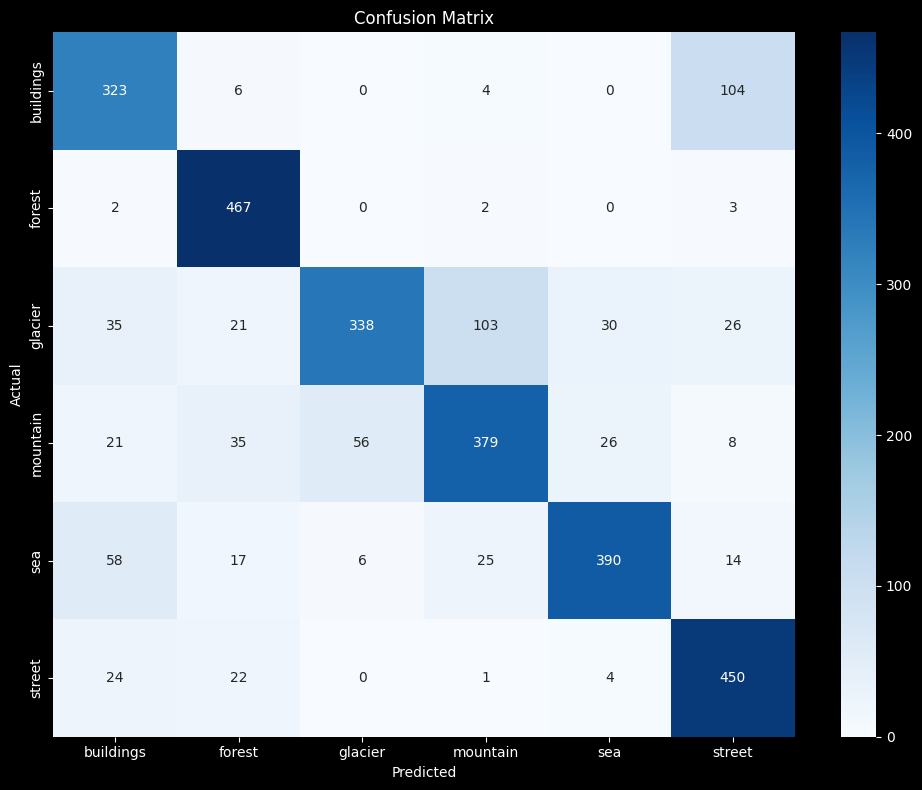


Точность по классам:
buildings: 0.739
forest: 0.985
glacier: 0.611
mountain: 0.722
sea: 0.765
street: 0.898


In [46]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [47]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.70      0.74      0.72       437
      forest       0.82      0.99      0.90       474
     glacier       0.84      0.61      0.71       553
    mountain       0.74      0.72      0.73       525
         sea       0.87      0.76      0.81       510
      street       0.74      0.90      0.81       501

    accuracy                           0.78      3000
   macro avg       0.79      0.79      0.78      3000
weighted avg       0.79      0.78      0.78      3000



## 3. Цветовые и яркостные преобразования
* Предыдущие аугментации +
* Изменение яркости (brightness) ±20%
* Изменение контраста (contrast) ±20%

In [48]:
def run_experiment(model, criterion, optimizer, scheduler, ratio):
    # Training
    train_transform = A.Compose([
        A.HorizontalFlip(p=ratio),
        A.Rotate(limit=(-15, 15), p=ratio),
        A.RandomScale(scale_limit=(0.9, 1.1), p=ratio),
        A.ShiftScaleRotate(shift_limit=(0.1, 0.1), scale_limit=0, 
                           rotate_limit=0, border_mode=cv2.BORDER_REFLECT, p=ratio),
        A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=ratio),
        A.Resize(150, 150),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    train_dataset = MyDataset(image_paths=train_img_path, 
                              labels=train_img_label, 
                              transform=train_transform)
    train_loader = DataLoader(train_dataset,
                              batch_size=128,
                              shuffle=True,
                              num_workers=0,
                              pin_memory=True)

    # Validation
    val_transform = A.Compose([
        A.Resize(150, 150),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    val_dataset = MyDataset(image_paths=val_img_path, 
                            labels=val_img_label, 
                            transform=val_transform)
    val_loader = DataLoader(val_dataset,
                            batch_size=128,
                            shuffle=False,
                            num_workers=0,
                            pin_memory=True)
    
    # Запуск обучения
    history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)

    return history

### 25% аугментированных данных

In [49]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=0.25)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.71it/s, Loss=0.0071, Acc=68.43%]



Epoch 1/10:
Train Loss: 0.0105, Train Acc: 48.32%
Val Loss: 0.0071, Val Acc: 68.43%
Time: 48.8s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 68.43%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.88it/s, Loss=0.0062, Acc=70.10%]



Epoch 2/10:
Train Loss: 0.0072, Train Acc: 65.34%
Val Loss: 0.0062, Val Acc: 70.10%
Time: 48.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 70.10%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s, Loss=0.0048, Acc=79.47%]



Epoch 3/10:
Train Loss: 0.0061, Train Acc: 71.77%
Val Loss: 0.0048, Val Acc: 79.47%
Time: 48.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 79.47%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.87it/s, Loss=0.0047, Acc=81.20%]



Epoch 4/10:
Train Loss: 0.0055, Train Acc: 75.27%
Val Loss: 0.0047, Val Acc: 81.20%
Time: 48.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 81.20%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.86it/s, Loss=0.0043, Acc=82.10%]



Epoch 5/10:
Train Loss: 0.0051, Train Acc: 77.33%
Val Loss: 0.0043, Val Acc: 82.10%
Time: 48.3s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 82.10%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.72it/s, Loss=0.0056, Acc=73.77%]



Epoch 6/10:
Train Loss: 0.0049, Train Acc: 78.67%
Val Loss: 0.0056, Val Acc: 73.77%
Time: 48.3s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.73it/s, Loss=0.0045, Acc=81.33%]



Epoch 7/10:
Train Loss: 0.0047, Train Acc: 79.32%
Val Loss: 0.0045, Val Acc: 81.33%
Time: 48.8s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.12it/s, Loss=0.0039, Acc=83.53%]



Epoch 8/10:
Train Loss: 0.0045, Train Acc: 80.13%
Val Loss: 0.0039, Val Acc: 83.53%
Time: 48.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 83.53%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.73it/s, Loss=0.0035, Acc=86.23%]



Epoch 9/10:
Train Loss: 0.0043, Train Acc: 81.20%
Val Loss: 0.0035, Val Acc: 86.23%
Time: 49.8s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 86.23%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.98it/s, Loss=0.0040, Acc=82.07%]


Epoch 10/10:
Train Loss: 0.0041, Train Acc: 81.89%
Val Loss: 0.0040, Val Acc: 82.07%
Time: 48.4s, LR: 0.001000
------------------------------------------------------------

Обучение завершено!
Общее время: 8.1 минут
Лучшая валидационная точность: 86.23%


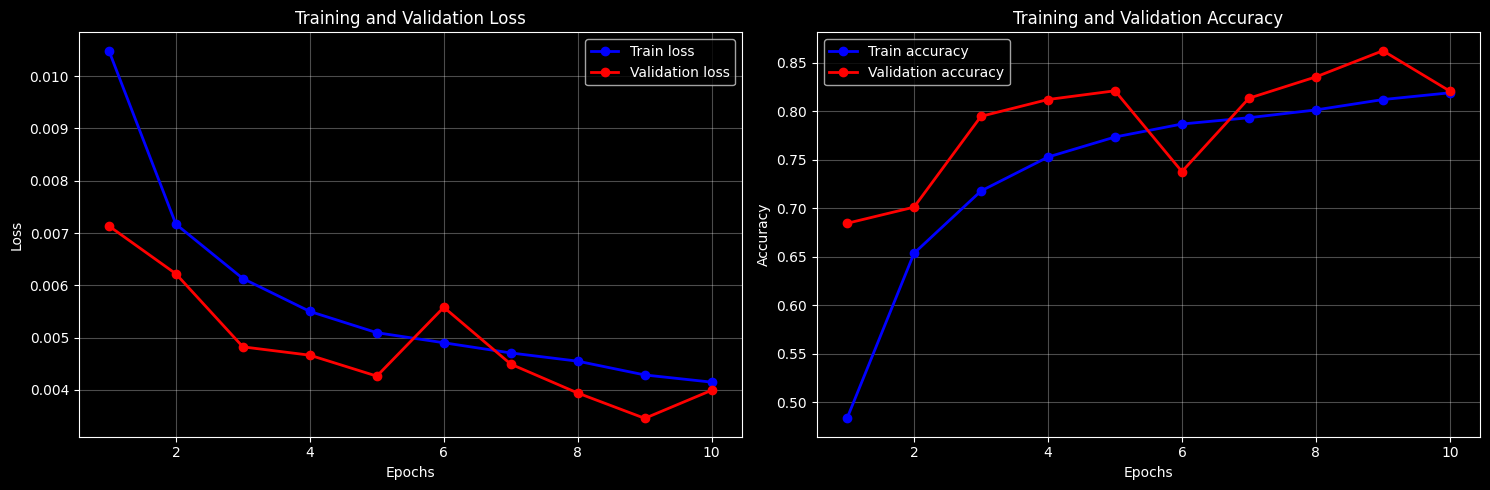

Final results
Best training accuracy: 81.89%
Best validation accuracy: 86.23%
Final train loss: 0.0041
Final validation loss: 0.0040


In [50]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.91it/s]


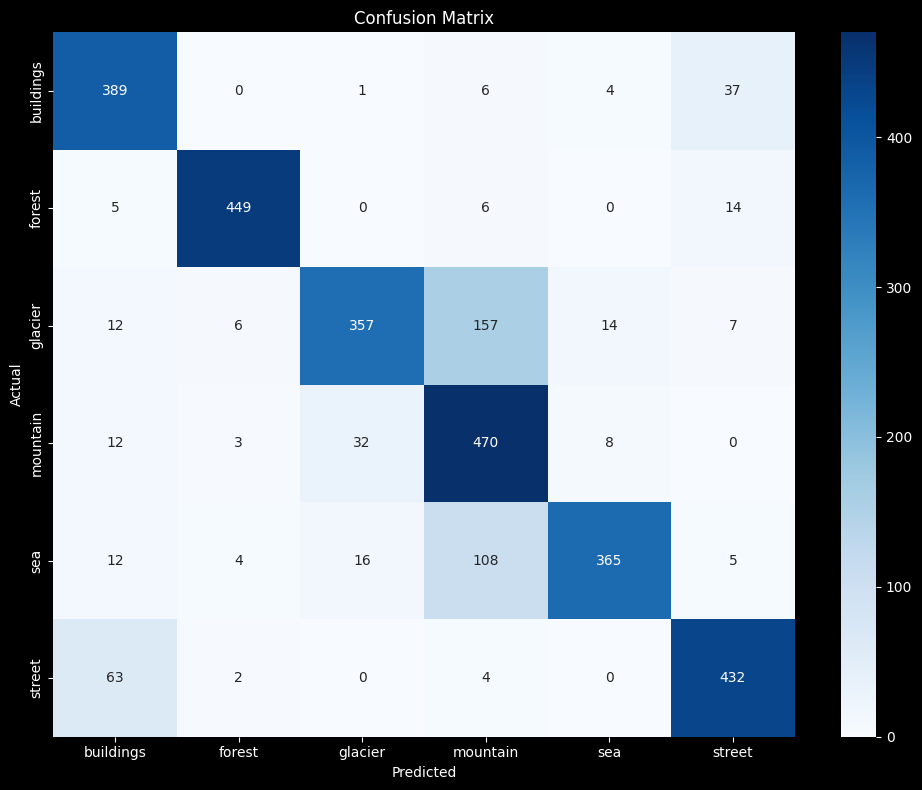


Точность по классам:
buildings: 0.890
forest: 0.947
glacier: 0.646
mountain: 0.895
sea: 0.716
street: 0.862


In [51]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [52]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.79      0.89      0.84       437
      forest       0.97      0.95      0.96       474
     glacier       0.88      0.65      0.74       553
    mountain       0.63      0.90      0.74       525
         sea       0.93      0.72      0.81       510
      street       0.87      0.86      0.87       501

    accuracy                           0.82      3000
   macro avg       0.84      0.83      0.83      3000
weighted avg       0.84      0.82      0.82      3000



### 50% аугментированных данных

In [53]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=0.5)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.91it/s, Loss=0.0074, Acc=62.97%]



Epoch 1/10:
Train Loss: 0.0109, Train Acc: 46.70%
Val Loss: 0.0074, Val Acc: 62.97%
Time: 54.9s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 62.97%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.99it/s, Loss=0.0064, Acc=68.23%]



Epoch 2/10:
Train Loss: 0.0077, Train Acc: 62.31%
Val Loss: 0.0064, Val Acc: 68.23%
Time: 55.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 68.23%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.78it/s, Loss=0.0054, Acc=77.50%]



Epoch 3/10:
Train Loss: 0.0065, Train Acc: 70.22%
Val Loss: 0.0054, Val Acc: 77.50%
Time: 56.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 77.50%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.70it/s, Loss=0.0047, Acc=78.67%]



Epoch 4/10:
Train Loss: 0.0058, Train Acc: 74.35%
Val Loss: 0.0047, Val Acc: 78.67%
Time: 56.8s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 78.67%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.78it/s, Loss=0.0053, Acc=75.90%]



Epoch 5/10:
Train Loss: 0.0055, Train Acc: 75.66%
Val Loss: 0.0053, Val Acc: 75.90%
Time: 56.2s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.86it/s, Loss=0.0061, Acc=75.03%]



Epoch 6/10:
Train Loss: 0.0052, Train Acc: 76.80%
Val Loss: 0.0061, Val Acc: 75.03%
Time: 55.9s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.70it/s, Loss=0.0039, Acc=83.83%]



Epoch 7/10:
Train Loss: 0.0050, Train Acc: 78.44%
Val Loss: 0.0039, Val Acc: 83.83%
Time: 57.2s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 83.83%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.73it/s, Loss=0.0040, Acc=83.23%]



Epoch 8/10:
Train Loss: 0.0047, Train Acc: 79.54%
Val Loss: 0.0040, Val Acc: 83.23%
Time: 56.3s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.75it/s, Loss=0.0037, Acc=83.60%]



Epoch 9/10:
Train Loss: 0.0046, Train Acc: 79.90%
Val Loss: 0.0037, Val Acc: 83.60%
Time: 56.5s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.67it/s, Loss=0.0036, Acc=85.00%]



Epoch 10/10:
Train Loss: 0.0045, Train Acc: 80.29%
Val Loss: 0.0036, Val Acc: 85.00%
Time: 57.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 85.00%
------------------------------------------------------------

Обучение завершено!
Общее время: 9.4 минут
Лучшая валидационная точность: 85.00%


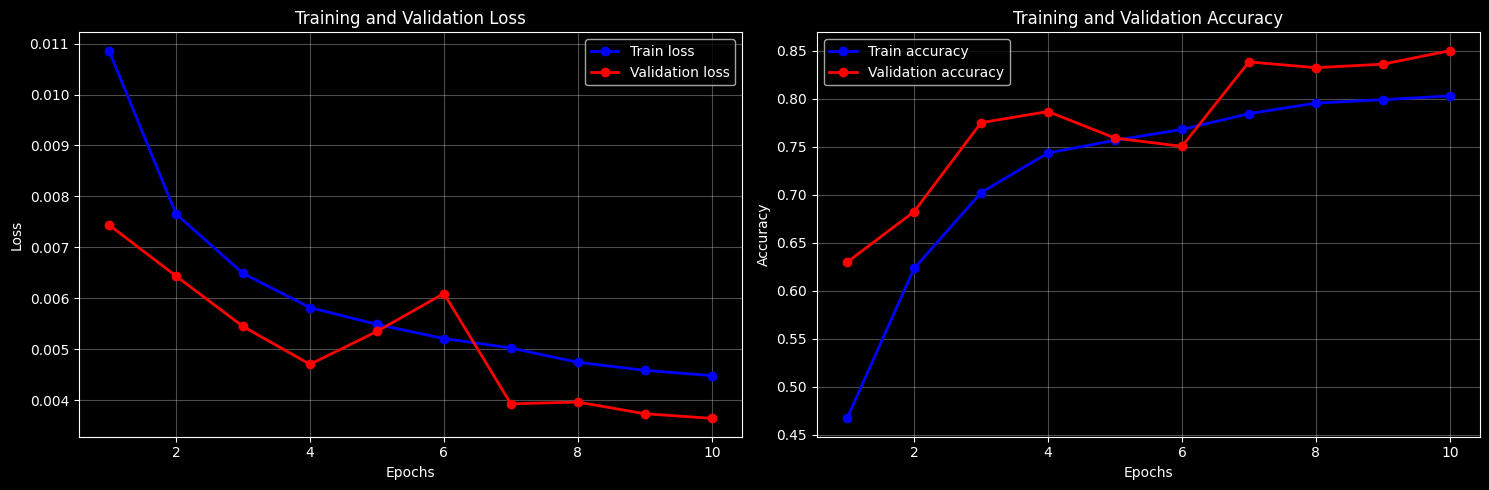

Final results
Best training accuracy: 80.29%
Best validation accuracy: 85.00%
Final train loss: 0.0045
Final validation loss: 0.0036


In [54]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.74it/s]


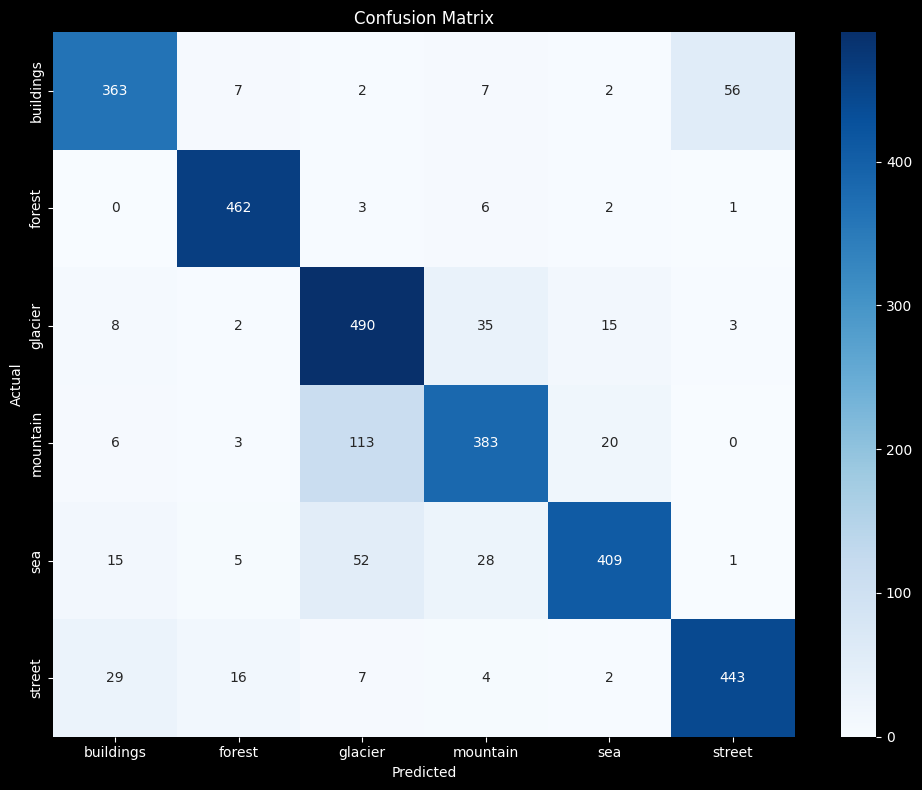


Точность по классам:
buildings: 0.831
forest: 0.975
glacier: 0.886
mountain: 0.730
sea: 0.802
street: 0.884


In [55]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [56]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.86      0.83      0.85       437
      forest       0.93      0.97      0.95       474
     glacier       0.73      0.89      0.80       553
    mountain       0.83      0.73      0.78       525
         sea       0.91      0.80      0.85       510
      street       0.88      0.88      0.88       501

    accuracy                           0.85      3000
   macro avg       0.86      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



### 75% аугментированных данных

In [57]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=0.75)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.74it/s, Loss=0.0121, Acc=47.60%]



Epoch 1/10:
Train Loss: 0.0112, Train Acc: 45.60%
Val Loss: 0.0121, Val Acc: 47.60%
Time: 66.8s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 47.60%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.70it/s, Loss=0.0070, Acc=68.97%]



Epoch 2/10:
Train Loss: 0.0080, Train Acc: 60.00%
Val Loss: 0.0070, Val Acc: 68.97%
Time: 66.3s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 68.97%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.74it/s, Loss=0.0056, Acc=75.43%]



Epoch 3/10:
Train Loss: 0.0070, Train Acc: 66.75%
Val Loss: 0.0056, Val Acc: 75.43%
Time: 66.0s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 75.43%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.92it/s, Loss=0.0053, Acc=76.57%]



Epoch 4/10:
Train Loss: 0.0062, Train Acc: 72.47%
Val Loss: 0.0053, Val Acc: 76.57%
Time: 65.2s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 76.57%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s, Loss=0.0062, Acc=73.17%]



Epoch 5/10:
Train Loss: 0.0057, Train Acc: 74.63%
Val Loss: 0.0062, Val Acc: 73.17%
Time: 65.1s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.86it/s, Loss=0.0048, Acc=80.17%]



Epoch 6/10:
Train Loss: 0.0054, Train Acc: 76.25%
Val Loss: 0.0048, Val Acc: 80.17%
Time: 65.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 80.17%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s, Loss=0.0051, Acc=77.37%]



Epoch 7/10:
Train Loss: 0.0050, Train Acc: 77.87%
Val Loss: 0.0051, Val Acc: 77.37%
Time: 64.9s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:07<00:00,  3.04it/s, Loss=0.0040, Acc=82.50%]



Epoch 8/10:
Train Loss: 0.0049, Train Acc: 78.25%
Val Loss: 0.0040, Val Acc: 82.50%
Time: 69.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 82.50%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:07<00:00,  3.37it/s, Loss=0.0037, Acc=84.40%]



Epoch 9/10:
Train Loss: 0.0048, Train Acc: 79.24%
Val Loss: 0.0037, Val Acc: 84.40%
Time: 70.9s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 84.40%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.60it/s, Loss=0.0052, Acc=78.27%]


Epoch 10/10:
Train Loss: 0.0045, Train Acc: 80.17%
Val Loss: 0.0052, Val Acc: 78.27%
Time: 67.8s, LR: 0.001000
------------------------------------------------------------

Обучение завершено!
Общее время: 11.1 минут
Лучшая валидационная точность: 84.40%


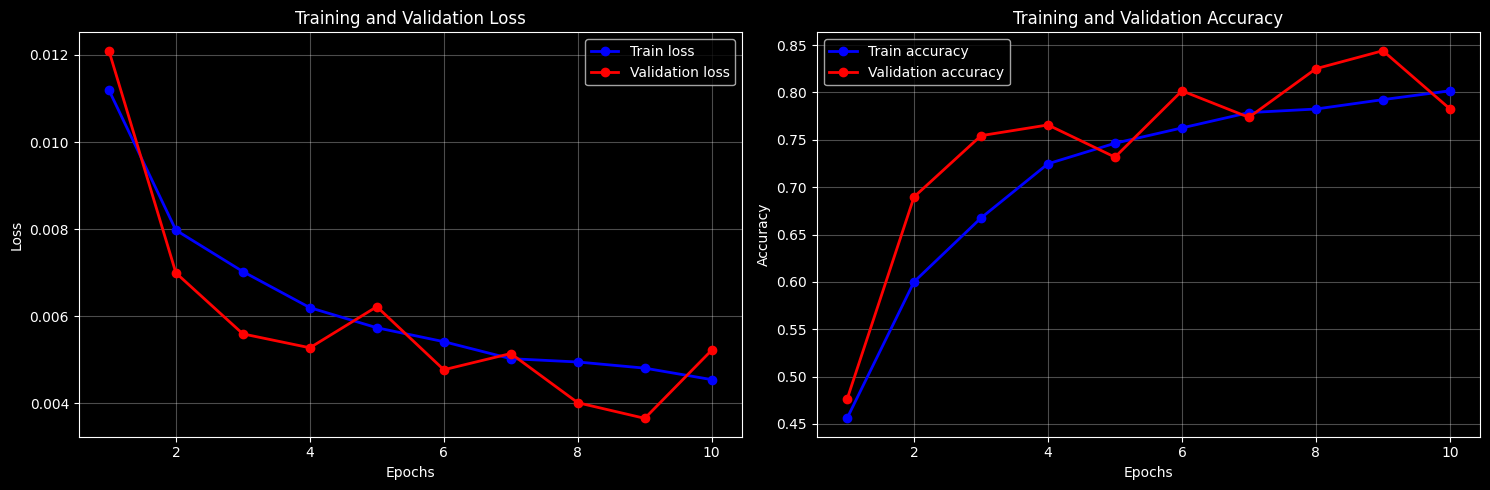

Final results
Best training accuracy: 80.17%
Best validation accuracy: 84.40%
Final train loss: 0.0045
Final validation loss: 0.0052


In [58]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.87it/s]


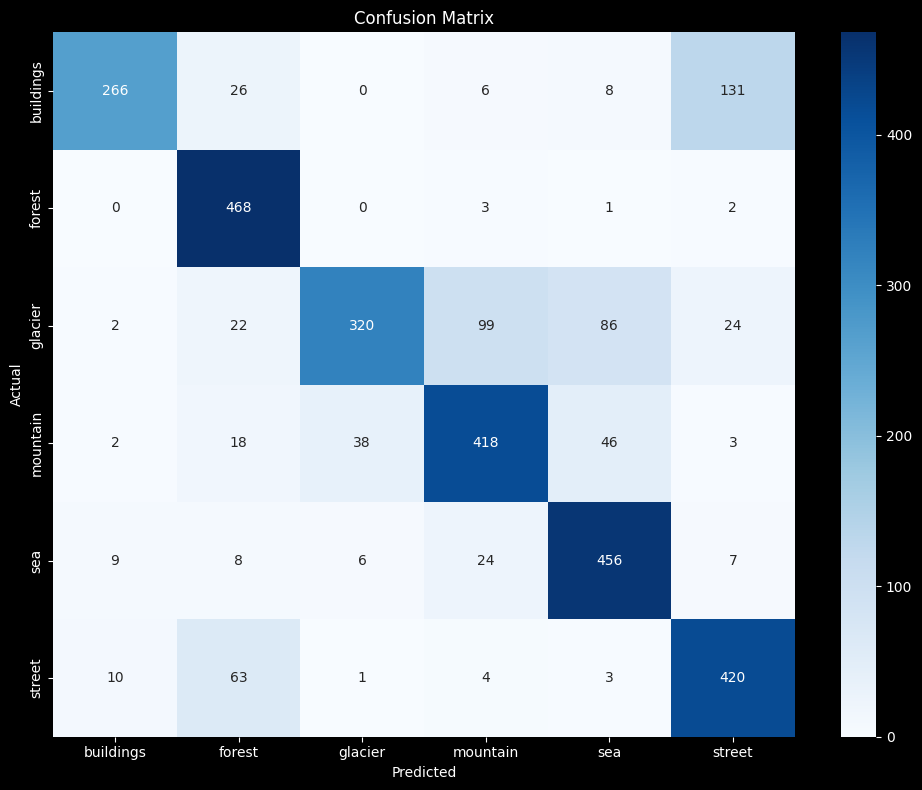


Точность по классам:
buildings: 0.609
forest: 0.987
glacier: 0.579
mountain: 0.796
sea: 0.894
street: 0.838


In [59]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [60]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.92      0.61      0.73       437
      forest       0.77      0.99      0.87       474
     glacier       0.88      0.58      0.70       553
    mountain       0.75      0.80      0.77       525
         sea       0.76      0.89      0.82       510
      street       0.72      0.84      0.77       501

    accuracy                           0.78      3000
   macro avg       0.80      0.78      0.78      3000
weighted avg       0.80      0.78      0.78      3000



### 100% аугментированных данных

In [61]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=1.0)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.91it/s, Loss=0.0109, Acc=46.23%]



Epoch 1/10:
Train Loss: 0.0121, Train Acc: 41.27%
Val Loss: 0.0109, Val Acc: 46.23%
Time: 75.2s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 46.23%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:07<00:00,  3.14it/s, Loss=0.0102, Acc=54.17%]



Epoch 2/10:
Train Loss: 0.0084, Train Acc: 57.35%
Val Loss: 0.0102, Val Acc: 54.17%
Time: 79.0s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 54.17%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.56it/s, Loss=0.0095, Acc=57.70%]



Epoch 3/10:
Train Loss: 0.0077, Train Acc: 61.61%
Val Loss: 0.0095, Val Acc: 57.70%
Time: 78.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 57.70%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.70it/s, Loss=0.0074, Acc=67.83%]



Epoch 4/10:
Train Loss: 0.0069, Train Acc: 66.29%
Val Loss: 0.0074, Val Acc: 67.83%
Time: 77.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 67.83%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.86it/s, Loss=0.0076, Acc=67.00%]



Epoch 5/10:
Train Loss: 0.0063, Train Acc: 70.70%
Val Loss: 0.0076, Val Acc: 67.00%
Time: 77.3s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.61it/s, Loss=0.0068, Acc=70.07%]



Epoch 6/10:
Train Loss: 0.0059, Train Acc: 73.26%
Val Loss: 0.0068, Val Acc: 70.07%
Time: 77.0s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 70.07%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.74it/s, Loss=0.0056, Acc=76.57%]



Epoch 7/10:
Train Loss: 0.0055, Train Acc: 75.68%
Val Loss: 0.0056, Val Acc: 76.57%
Time: 77.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 76.57%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.86it/s, Loss=0.0072, Acc=68.20%]



Epoch 8/10:
Train Loss: 0.0051, Train Acc: 77.78%
Val Loss: 0.0072, Val Acc: 68.20%
Time: 75.2s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s, Loss=0.0045, Acc=81.07%]



Epoch 9/10:
Train Loss: 0.0050, Train Acc: 78.50%
Val Loss: 0.0045, Val Acc: 81.07%
Time: 74.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 81.07%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.65it/s, Loss=0.0056, Acc=74.80%]


Epoch 10/10:
Train Loss: 0.0047, Train Acc: 79.28%
Val Loss: 0.0056, Val Acc: 74.80%
Time: 75.0s, LR: 0.001000
------------------------------------------------------------

Обучение завершено!
Общее время: 12.8 минут
Лучшая валидационная точность: 81.07%


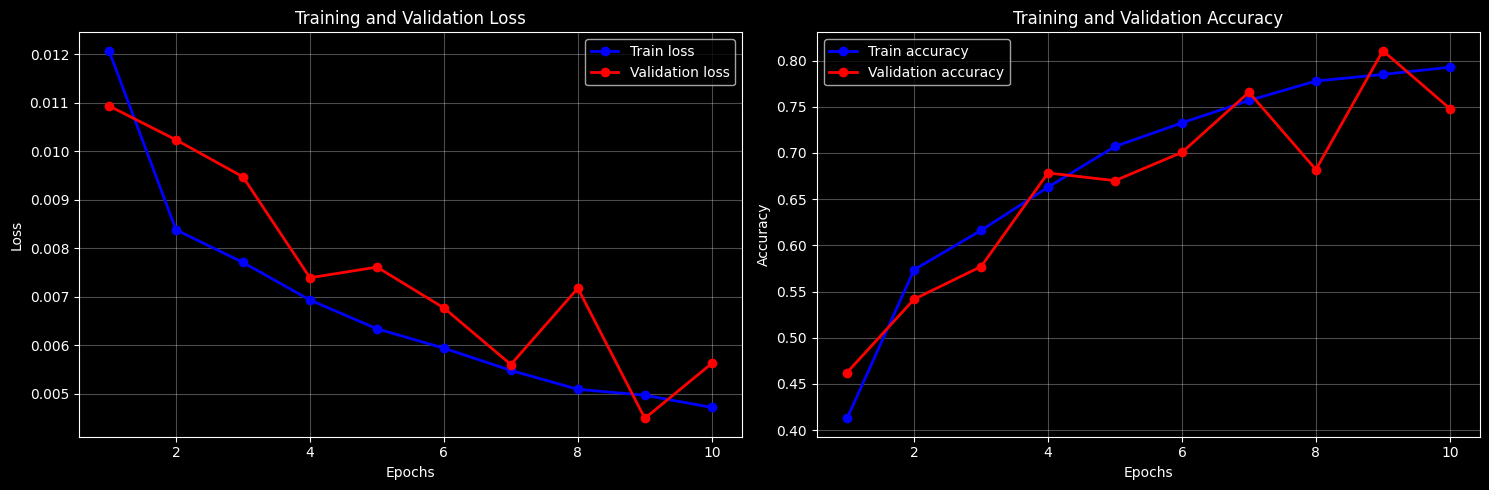

Final results
Best training accuracy: 79.28%
Best validation accuracy: 81.07%
Final train loss: 0.0047
Final validation loss: 0.0056


In [62]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.77it/s]


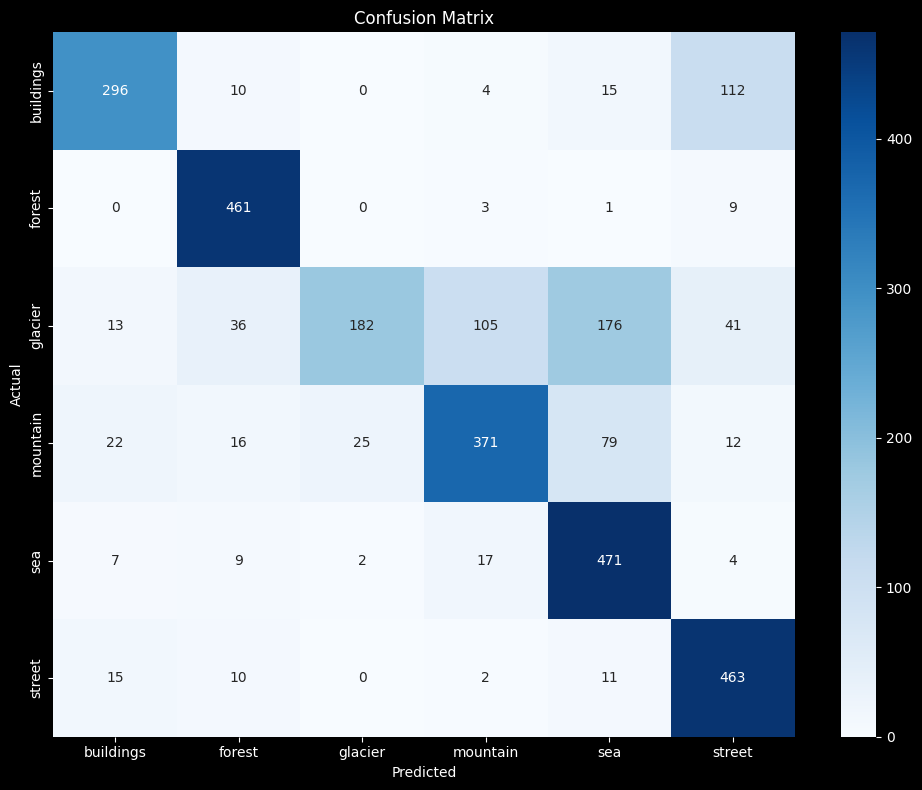


Точность по классам:
buildings: 0.677
forest: 0.973
glacier: 0.329
mountain: 0.707
sea: 0.924
street: 0.924


In [63]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [64]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.84      0.68      0.75       437
      forest       0.85      0.97      0.91       474
     glacier       0.87      0.33      0.48       553
    mountain       0.74      0.71      0.72       525
         sea       0.63      0.92      0.75       510
      street       0.72      0.92      0.81       501

    accuracy                           0.75      3000
   macro avg       0.77      0.76      0.74      3000
weighted avg       0.77      0.75      0.73      3000



## 4. Продвинутые техники
* Предыдущие аугментации +
* Размытие (Gaussian blur)
* Добавление шума (noise injection)

In [65]:
def run_experiment(model, criterion, optimizer, scheduler, ratio):
    # Training
    train_transform = A.Compose([
        A.HorizontalFlip(p=ratio),
        A.Rotate(limit=(-15, 15), p=ratio),
        A.RandomScale(scale_limit=(0.9, 1.1), p=ratio),
        A.ShiftScaleRotate(shift_limit=(0.1, 0.1), scale_limit=0, 
                           rotate_limit=0, border_mode=cv2.BORDER_REFLECT, p=ratio),
        A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=ratio),
        A.GaussianBlur(sigma_limit=(0.1, 0.2), p=ratio),
        A.GaussNoise(p=ratio),
        A.Resize(150, 150),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    train_dataset = MyDataset(image_paths=train_img_path, 
                              labels=train_img_label, 
                              transform=train_transform)
    train_loader = DataLoader(train_dataset,
                              batch_size=128,
                              shuffle=True,
                              num_workers=0,
                              pin_memory=True)

    # Validation
    val_transform = A.Compose([
        A.Resize(150, 150),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    val_dataset = MyDataset(image_paths=val_img_path, 
                            labels=val_img_label, 
                            transform=val_transform)
    val_loader = DataLoader(val_dataset,
                            batch_size=128,
                            shuffle=False,
                            num_workers=0,
                            pin_memory=True)
    
    # Запуск обучения
    history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)

    return history

### 25% аугментированных данных

In [66]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=0.25)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.94it/s, Loss=0.0090, Acc=53.57%]



Epoch 1/10:
Train Loss: 0.0119, Train Acc: 40.32%
Val Loss: 0.0090, Val Acc: 53.57%
Time: 54.9s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 53.57%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.83it/s, Loss=0.0089, Acc=54.37%]



Epoch 2/10:
Train Loss: 0.0087, Train Acc: 55.46%
Val Loss: 0.0089, Val Acc: 54.37%
Time: 54.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 54.37%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.51it/s, Loss=0.0073, Acc=64.53%]



Epoch 3/10:
Train Loss: 0.0081, Train Acc: 60.08%
Val Loss: 0.0073, Val Acc: 64.53%
Time: 55.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 64.53%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.58it/s, Loss=0.0055, Acc=76.57%]



Epoch 4/10:
Train Loss: 0.0072, Train Acc: 65.76%
Val Loss: 0.0055, Val Acc: 76.57%
Time: 57.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 76.57%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.93it/s, Loss=0.0052, Acc=77.77%]



Epoch 5/10:
Train Loss: 0.0066, Train Acc: 69.42%
Val Loss: 0.0052, Val Acc: 77.77%
Time: 55.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 77.77%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s, Loss=0.0047, Acc=80.13%]



Epoch 6/10:
Train Loss: 0.0061, Train Acc: 72.01%
Val Loss: 0.0047, Val Acc: 80.13%
Time: 55.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 80.13%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.99it/s, Loss=0.0046, Acc=80.47%]



Epoch 7/10:
Train Loss: 0.0060, Train Acc: 73.88%
Val Loss: 0.0046, Val Acc: 80.47%
Time: 55.6s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 80.47%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.89it/s, Loss=0.0046, Acc=80.90%]



Epoch 8/10:
Train Loss: 0.0055, Train Acc: 75.16%
Val Loss: 0.0046, Val Acc: 80.90%
Time: 55.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 80.90%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.90it/s, Loss=0.0044, Acc=82.07%]



Epoch 9/10:
Train Loss: 0.0055, Train Acc: 75.47%
Val Loss: 0.0044, Val Acc: 82.07%
Time: 55.2s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 82.07%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.81it/s, Loss=0.0041, Acc=82.87%]



Epoch 10/10:
Train Loss: 0.0052, Train Acc: 76.93%
Val Loss: 0.0041, Val Acc: 82.87%
Time: 55.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 82.87%
------------------------------------------------------------

Обучение завершено!
Общее время: 9.3 минут
Лучшая валидационная точность: 82.87%


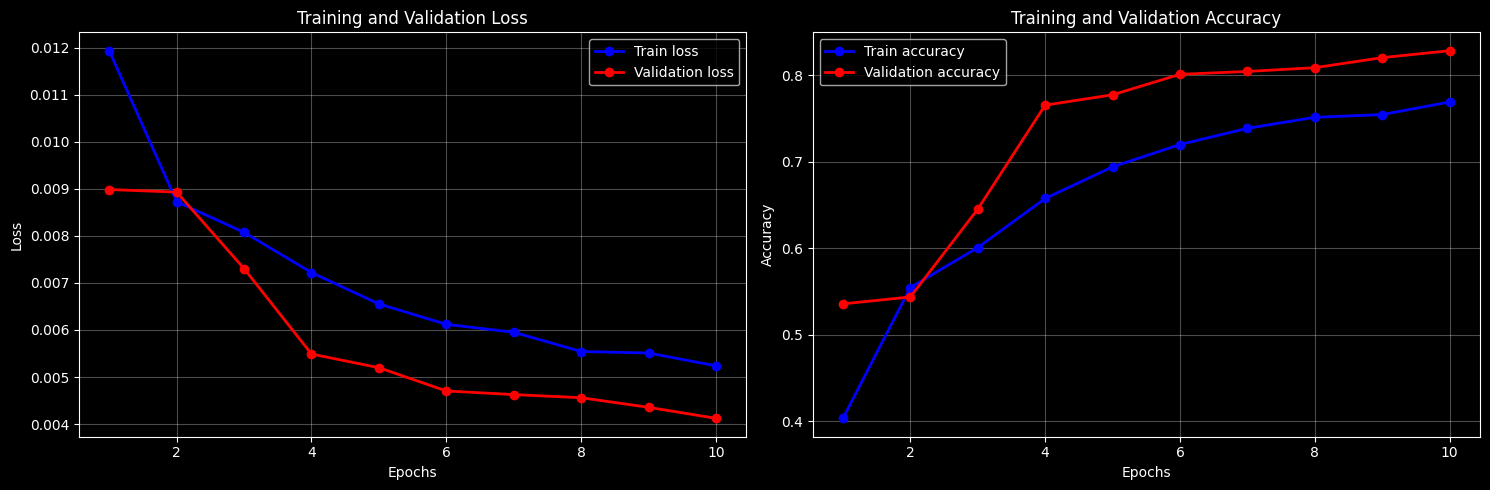

Final results
Best training accuracy: 76.93%
Best validation accuracy: 82.87%
Final train loss: 0.0052
Final validation loss: 0.0041


In [67]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.96it/s]


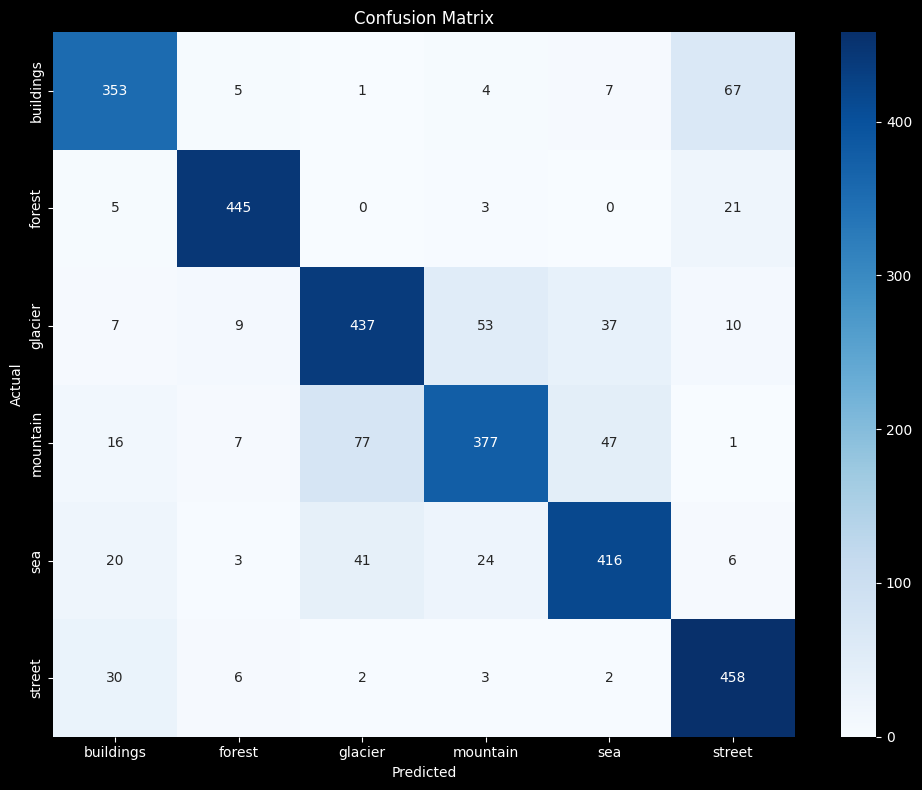


Точность по классам:
buildings: 0.808
forest: 0.939
glacier: 0.790
mountain: 0.718
sea: 0.816
street: 0.914


In [68]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [69]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.82      0.81      0.81       437
      forest       0.94      0.94      0.94       474
     glacier       0.78      0.79      0.79       553
    mountain       0.81      0.72      0.76       525
         sea       0.82      0.82      0.82       510
      street       0.81      0.91      0.86       501

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



### 50% аугментированных данных

In [70]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=0.5)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.85it/s, Loss=0.0088, Acc=56.40%]



Epoch 1/10:
Train Loss: 0.0125, Train Acc: 38.71%
Val Loss: 0.0088, Val Acc: 56.40%
Time: 72.6s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 56.40%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s, Loss=0.0079, Acc=59.03%]



Epoch 2/10:
Train Loss: 0.0091, Train Acc: 53.40%
Val Loss: 0.0079, Val Acc: 59.03%
Time: 76.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 59.03%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.84it/s, Loss=0.0073, Acc=64.67%]



Epoch 3/10:
Train Loss: 0.0084, Train Acc: 57.75%
Val Loss: 0.0073, Val Acc: 64.67%
Time: 74.3s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 64.67%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s, Loss=0.0076, Acc=63.53%]



Epoch 4/10:
Train Loss: 0.0080, Train Acc: 60.65%
Val Loss: 0.0076, Val Acc: 63.53%
Time: 72.6s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.10it/s, Loss=0.0065, Acc=69.57%]



Epoch 5/10:
Train Loss: 0.0077, Train Acc: 61.86%
Val Loss: 0.0065, Val Acc: 69.57%
Time: 72.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 69.57%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.80it/s, Loss=0.0067, Acc=70.60%]



Epoch 6/10:
Train Loss: 0.0073, Train Acc: 64.32%
Val Loss: 0.0067, Val Acc: 70.60%
Time: 73.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 70.60%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.89it/s, Loss=0.0057, Acc=75.10%]



Epoch 7/10:
Train Loss: 0.0070, Train Acc: 66.65%
Val Loss: 0.0057, Val Acc: 75.10%
Time: 72.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 75.10%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.94it/s, Loss=0.0052, Acc=77.40%]



Epoch 8/10:
Train Loss: 0.0066, Train Acc: 69.54%
Val Loss: 0.0052, Val Acc: 77.40%
Time: 73.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 77.40%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s, Loss=0.0049, Acc=79.50%]



Epoch 9/10:
Train Loss: 0.0064, Train Acc: 70.15%
Val Loss: 0.0049, Val Acc: 79.50%
Time: 73.2s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 79.50%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.84it/s, Loss=0.0054, Acc=76.70%]


Epoch 10/10:
Train Loss: 0.0061, Train Acc: 72.74%
Val Loss: 0.0054, Val Acc: 76.70%
Time: 73.2s, LR: 0.001000
------------------------------------------------------------

Обучение завершено!
Общее время: 12.2 минут
Лучшая валидационная точность: 79.50%


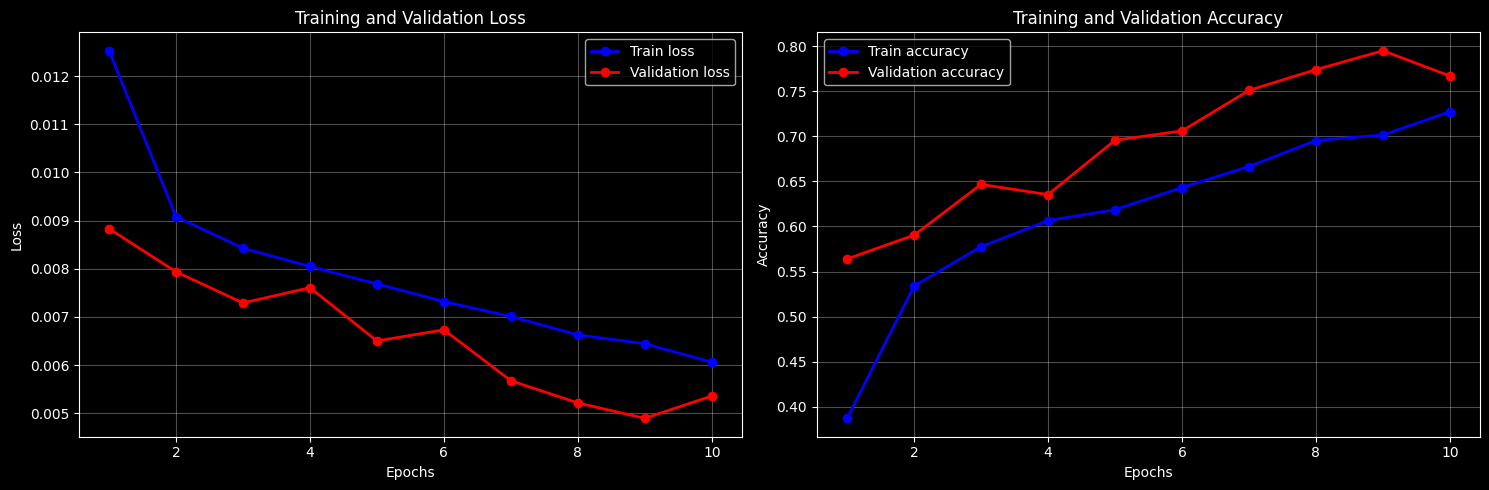

Final results
Best training accuracy: 72.74%
Best validation accuracy: 79.50%
Final train loss: 0.0061
Final validation loss: 0.0054


In [71]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.89it/s]


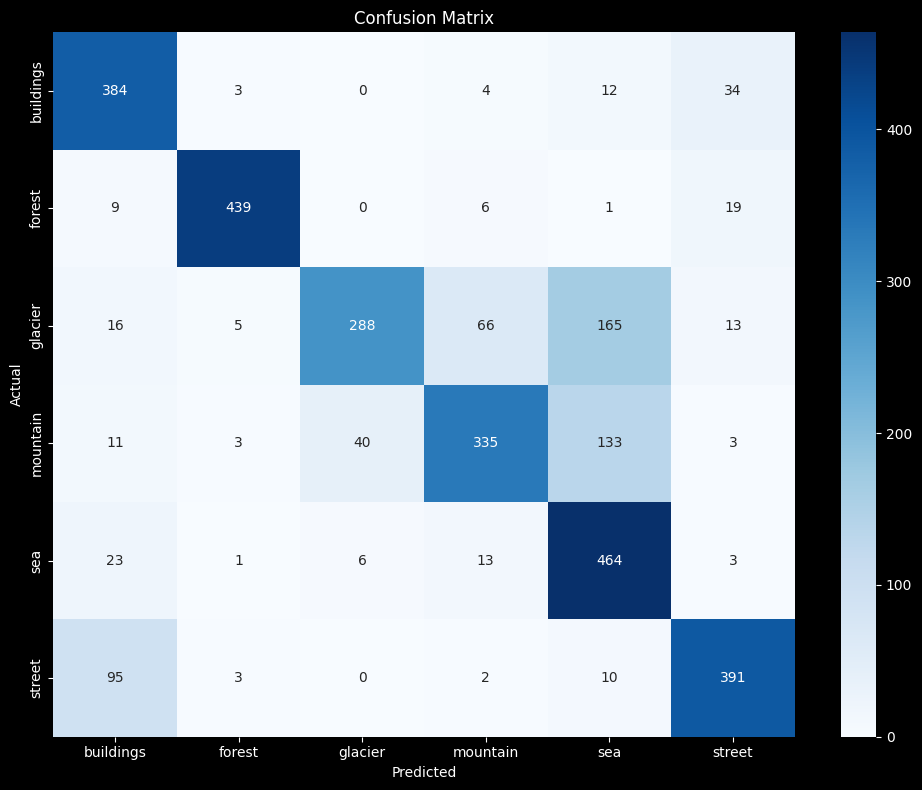


Точность по классам:
buildings: 0.879
forest: 0.926
glacier: 0.521
mountain: 0.638
sea: 0.910
street: 0.780


In [72]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [73]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.71      0.88      0.79       437
      forest       0.97      0.93      0.95       474
     glacier       0.86      0.52      0.65       553
    mountain       0.79      0.64      0.70       525
         sea       0.59      0.91      0.72       510
      street       0.84      0.78      0.81       501

    accuracy                           0.77      3000
   macro avg       0.79      0.78      0.77      3000
weighted avg       0.79      0.77      0.76      3000



### 75% аугментированных данных

In [74]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=0.75)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.88it/s, Loss=0.0092, Acc=51.77%]



Epoch 1/10:
Train Loss: 0.0130, Train Acc: 34.77%
Val Loss: 0.0092, Val Acc: 51.77%
Time: 97.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 51.77%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.94it/s, Loss=0.0083, Acc=60.40%]



Epoch 2/10:
Train Loss: 0.0096, Train Acc: 49.77%
Val Loss: 0.0083, Val Acc: 60.40%
Time: 96.3s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 60.40%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.98it/s, Loss=0.0076, Acc=63.63%]



Epoch 3/10:
Train Loss: 0.0088, Train Acc: 55.43%
Val Loss: 0.0076, Val Acc: 63.63%
Time: 97.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 63.63%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.78it/s, Loss=0.0072, Acc=66.80%]



Epoch 4/10:
Train Loss: 0.0083, Train Acc: 58.98%
Val Loss: 0.0072, Val Acc: 66.80%
Time: 97.6s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 66.80%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.66it/s, Loss=0.0071, Acc=65.07%]



Epoch 5/10:
Train Loss: 0.0078, Train Acc: 62.64%
Val Loss: 0.0071, Val Acc: 65.07%
Time: 98.8s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s, Loss=0.0066, Acc=70.73%]



Epoch 6/10:
Train Loss: 0.0074, Train Acc: 64.89%
Val Loss: 0.0066, Val Acc: 70.73%
Time: 100.0s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 70.73%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.88it/s, Loss=0.0055, Acc=75.83%]



Epoch 7/10:
Train Loss: 0.0071, Train Acc: 66.73%
Val Loss: 0.0055, Val Acc: 75.83%
Time: 97.9s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 75.83%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.89it/s, Loss=0.0052, Acc=76.37%]



Epoch 8/10:
Train Loss: 0.0068, Train Acc: 68.50%
Val Loss: 0.0052, Val Acc: 76.37%
Time: 95.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 76.37%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.87it/s, Loss=0.0061, Acc=73.63%]



Epoch 9/10:
Train Loss: 0.0066, Train Acc: 70.02%
Val Loss: 0.0061, Val Acc: 73.63%
Time: 96.9s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.71it/s, Loss=0.0053, Acc=77.20%]



Epoch 10/10:
Train Loss: 0.0063, Train Acc: 71.65%
Val Loss: 0.0053, Val Acc: 77.20%
Time: 97.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 77.20%
------------------------------------------------------------

Обучение завершено!
Общее время: 16.3 минут
Лучшая валидационная точность: 77.20%


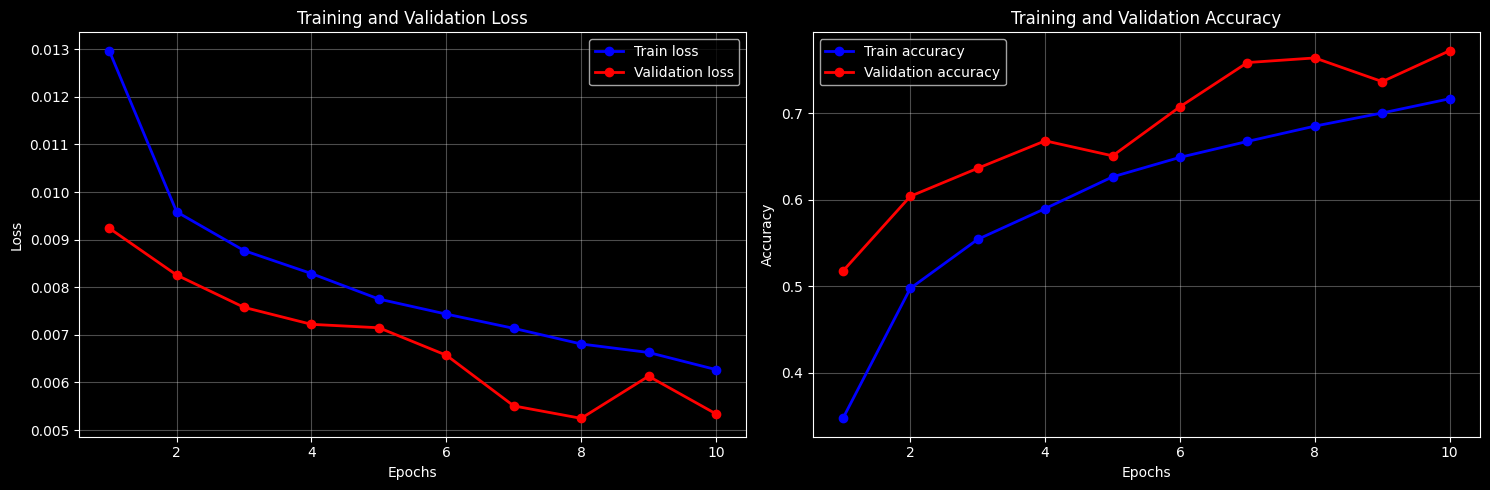

Final results
Best training accuracy: 71.65%
Best validation accuracy: 77.20%
Final train loss: 0.0063
Final validation loss: 0.0053


In [75]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.65it/s]


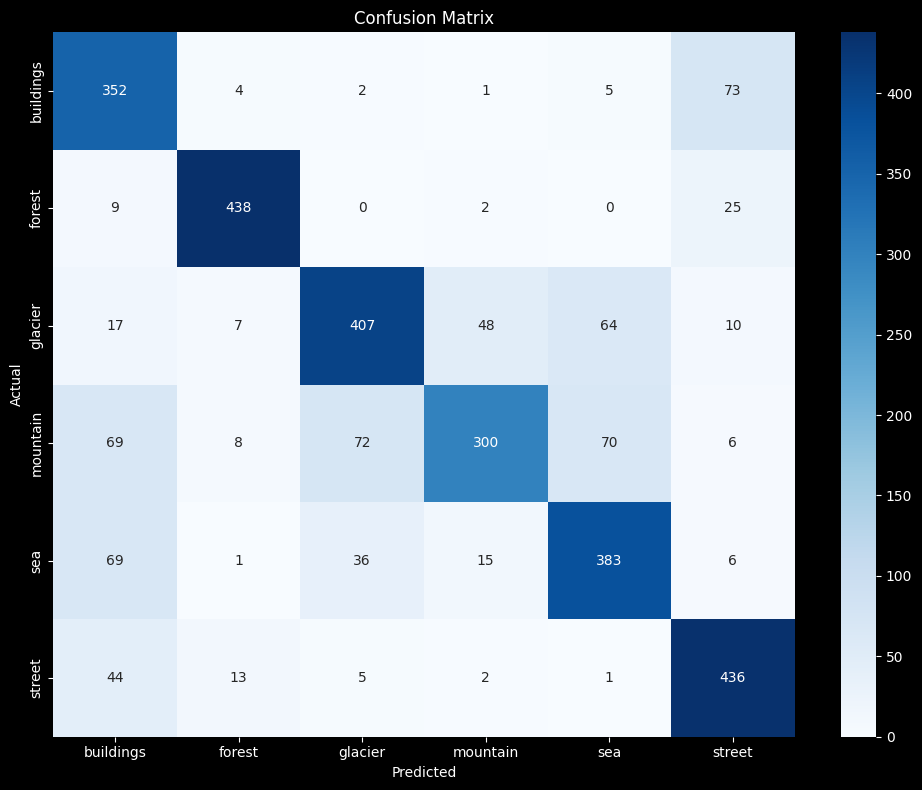


Точность по классам:
buildings: 0.805
forest: 0.924
glacier: 0.736
mountain: 0.571
sea: 0.751
street: 0.870


In [76]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [77]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.63      0.81      0.71       437
      forest       0.93      0.92      0.93       474
     glacier       0.78      0.74      0.76       553
    mountain       0.82      0.57      0.67       525
         sea       0.73      0.75      0.74       510
      street       0.78      0.87      0.82       501

    accuracy                           0.77      3000
   macro avg       0.78      0.78      0.77      3000
weighted avg       0.78      0.77      0.77      3000



### 100% аугментированных данных

In [78]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=1.0)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.72it/s, Loss=0.0107, Acc=46.57%]



Epoch 1/10:
Train Loss: 0.0130, Train Acc: 36.50%
Val Loss: 0.0107, Val Acc: 46.57%
Time: 129.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 46.57%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.83it/s, Loss=0.0100, Acc=48.73%]



Epoch 2/10:
Train Loss: 0.0094, Train Acc: 51.43%
Val Loss: 0.0100, Val Acc: 48.73%
Time: 132.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 48.73%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.87it/s, Loss=0.0085, Acc=59.47%]



Epoch 3/10:
Train Loss: 0.0087, Train Acc: 55.94%
Val Loss: 0.0085, Val Acc: 59.47%
Time: 128.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 59.47%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.69it/s, Loss=0.0091, Acc=56.20%]



Epoch 4/10:
Train Loss: 0.0083, Train Acc: 58.67%
Val Loss: 0.0091, Val Acc: 56.20%
Time: 129.2s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.60it/s, Loss=0.0070, Acc=66.93%]



Epoch 5/10:
Train Loss: 0.0078, Train Acc: 61.53%
Val Loss: 0.0070, Val Acc: 66.93%
Time: 128.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 66.93%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.60it/s, Loss=0.0073, Acc=67.10%]



Epoch 6/10:
Train Loss: 0.0075, Train Acc: 63.84%
Val Loss: 0.0073, Val Acc: 67.10%
Time: 127.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 67.10%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.77it/s, Loss=0.0075, Acc=64.10%]



Epoch 7/10:
Train Loss: 0.0072, Train Acc: 65.75%
Val Loss: 0.0075, Val Acc: 64.10%
Time: 128.9s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s, Loss=0.0064, Acc=70.87%]



Epoch 8/10:
Train Loss: 0.0069, Train Acc: 67.11%
Val Loss: 0.0064, Val Acc: 70.87%
Time: 128.2s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 70.87%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.84it/s, Loss=0.0072, Acc=67.53%]



Epoch 9/10:
Train Loss: 0.0068, Train Acc: 68.96%
Val Loss: 0.0072, Val Acc: 67.53%
Time: 129.9s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.74it/s, Loss=0.0100, Acc=61.13%]


Epoch 10/10:
Train Loss: 0.0064, Train Acc: 70.73%
Val Loss: 0.0100, Val Acc: 61.13%
Time: 130.6s, LR: 0.001000
------------------------------------------------------------

Обучение завершено!
Общее время: 21.6 минут
Лучшая валидационная точность: 70.87%


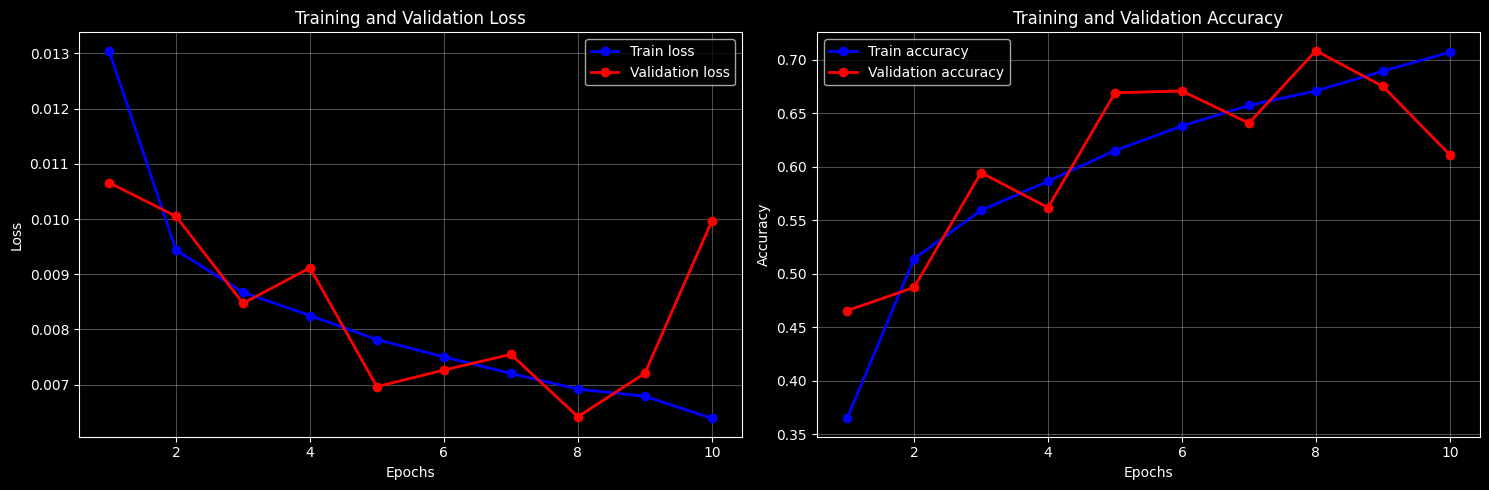

Final results
Best training accuracy: 70.73%
Best validation accuracy: 70.87%
Final train loss: 0.0064
Final validation loss: 0.0100


In [79]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.80it/s]


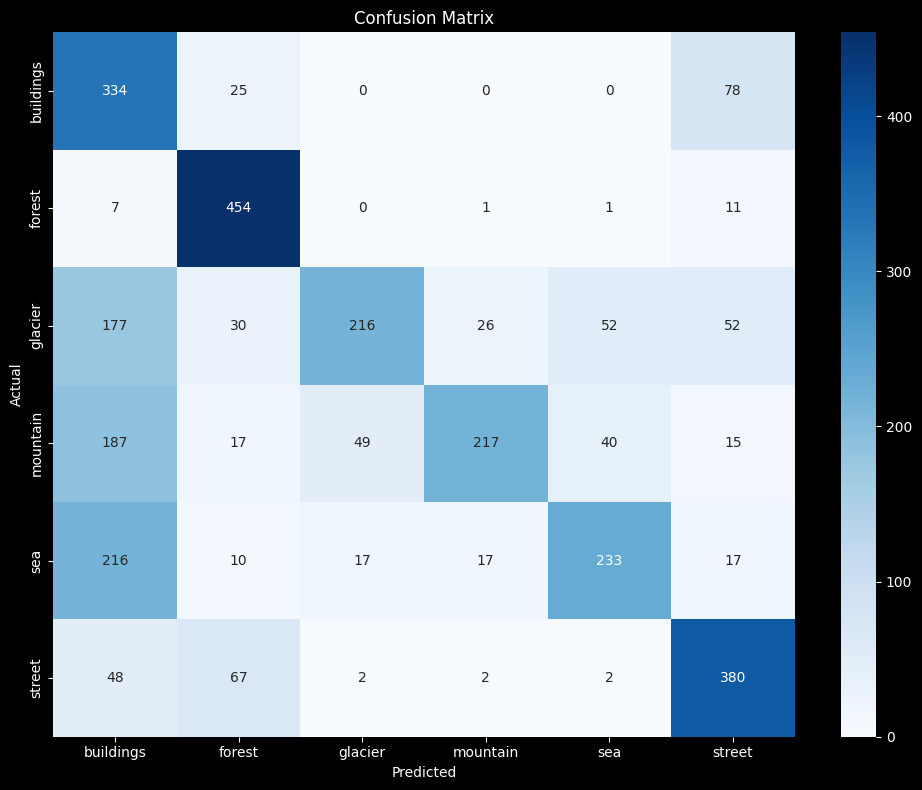


Точность по классам:
buildings: 0.764
forest: 0.958
glacier: 0.391
mountain: 0.413
sea: 0.457
street: 0.758


In [80]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [81]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.34      0.76      0.48       437
      forest       0.75      0.96      0.84       474
     glacier       0.76      0.39      0.52       553
    mountain       0.83      0.41      0.55       525
         sea       0.71      0.46      0.56       510
      street       0.69      0.76      0.72       501

    accuracy                           0.61      3000
   macro avg       0.68      0.62      0.61      3000
weighted avg       0.69      0.61      0.61      3000



## 5. Современные аугментации
* Предыдущие аугментации +
* Random Erasing
* CutMix

In [82]:
# CutMix в Albumentations нет, придется писать кастомный
class CutMix(A.DualTransform):
    def __init__(self, always_apply=False, p=0.5):
        super().__init__(always_apply, p)

    def apply(self, image, **params):
        return image

    def get_params_dependent_on_targets(self, params):
        image = params["image"]
        h, w, _ = image.shape
        cut_w = w // 2
        cut_h = h // 2
        x1 = np.random.randint(0, w - cut_w)
        y1 = np.random.randint(0, h - cut_h)
        return {"x1": x1, "y1": y1, "cut_w": cut_w, "cut_h": cut_h}

    def apply_with_other(self, image, other_image, x1, y1, cut_w, cut_h, **params):
        img = image.copy()
        img[y1:y1+cut_h, x1:x1+cut_w] = other_image[y1:y1+cut_h, x1:x1+cut_w]
        return img

    @property
    def targets_as_params(self):
        return ["image"]

    def update_params(self, params, **kwargs):
        return params

In [83]:
def run_experiment(model, criterion, optimizer, scheduler, ratio):
    # Training
    train_transform = A.Compose([
        A.HorizontalFlip(p=ratio),
        A.Rotate(limit=(-15, 15), p=ratio),
        A.RandomScale(scale_limit=(0.9, 1.1), p=ratio),
        A.ShiftScaleRotate(shift_limit=(0.1, 0.1), scale_limit=0, 
                           rotate_limit=0, border_mode=cv2.BORDER_REFLECT, p=ratio),
        A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=ratio),
        A.GaussianBlur(sigma_limit=(0.1, 0.2), p=ratio),
        A.GaussNoise(p=ratio),
        A.Erasing(p=ratio),
        CutMix(p=ratio),
        A.Resize(150, 150),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    train_dataset = MyDataset(image_paths=train_img_path, 
                              labels=train_img_label, 
                              transform=train_transform)
    train_loader = DataLoader(train_dataset,
                              batch_size=128,
                              shuffle=True,
                              num_workers=0,
                              pin_memory=True)

    # Validation
    val_transform = A.Compose([
        A.Resize(150, 150),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    val_dataset = MyDataset(image_paths=val_img_path, 
                            labels=val_img_label, 
                            transform=val_transform)
    val_loader = DataLoader(val_dataset,
                            batch_size=128,
                            shuffle=False,
                            num_workers=0,
                            pin_memory=True)
    
    # Запуск обучения
    history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)

    return history

### 25% аугментированных данных

In [84]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=0.25)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.63it/s, Loss=0.0084, Acc=58.17%]



Epoch 1/10:
Train Loss: 0.0117, Train Acc: 41.53%
Val Loss: 0.0084, Val Acc: 58.17%
Time: 55.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 58.17%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.72it/s, Loss=0.0075, Acc=60.93%]



Epoch 2/10:
Train Loss: 0.0088, Train Acc: 54.51%
Val Loss: 0.0075, Val Acc: 60.93%
Time: 56.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 60.93%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.95it/s, Loss=0.0064, Acc=70.33%]



Epoch 3/10:
Train Loss: 0.0082, Train Acc: 60.23%
Val Loss: 0.0064, Val Acc: 70.33%
Time: 56.0s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 70.33%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.09it/s, Loss=0.0059, Acc=73.10%]



Epoch 4/10:
Train Loss: 0.0077, Train Acc: 62.43%
Val Loss: 0.0059, Val Acc: 73.10%
Time: 55.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 73.10%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.22it/s, Loss=0.0056, Acc=73.13%]



Epoch 5/10:
Train Loss: 0.0070, Train Acc: 66.46%
Val Loss: 0.0056, Val Acc: 73.13%
Time: 54.9s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 73.13%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s, Loss=0.0055, Acc=76.43%]



Epoch 6/10:
Train Loss: 0.0066, Train Acc: 69.32%
Val Loss: 0.0055, Val Acc: 76.43%
Time: 55.6s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 76.43%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.00it/s, Loss=0.0051, Acc=77.27%]



Epoch 7/10:
Train Loss: 0.0063, Train Acc: 71.15%
Val Loss: 0.0051, Val Acc: 77.27%
Time: 55.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 77.27%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.67it/s, Loss=0.0055, Acc=78.57%]



Epoch 8/10:
Train Loss: 0.0059, Train Acc: 73.94%
Val Loss: 0.0055, Val Acc: 78.57%
Time: 57.0s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 78.57%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.72it/s, Loss=0.0045, Acc=80.53%]



Epoch 9/10:
Train Loss: 0.0058, Train Acc: 73.89%
Val Loss: 0.0045, Val Acc: 80.53%
Time: 56.6s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 80.53%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.90it/s, Loss=0.0044, Acc=81.37%]



Epoch 10/10:
Train Loss: 0.0056, Train Acc: 74.93%
Val Loss: 0.0044, Val Acc: 81.37%
Time: 56.2s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 81.37%
------------------------------------------------------------

Обучение завершено!
Общее время: 9.3 минут
Лучшая валидационная точность: 81.37%


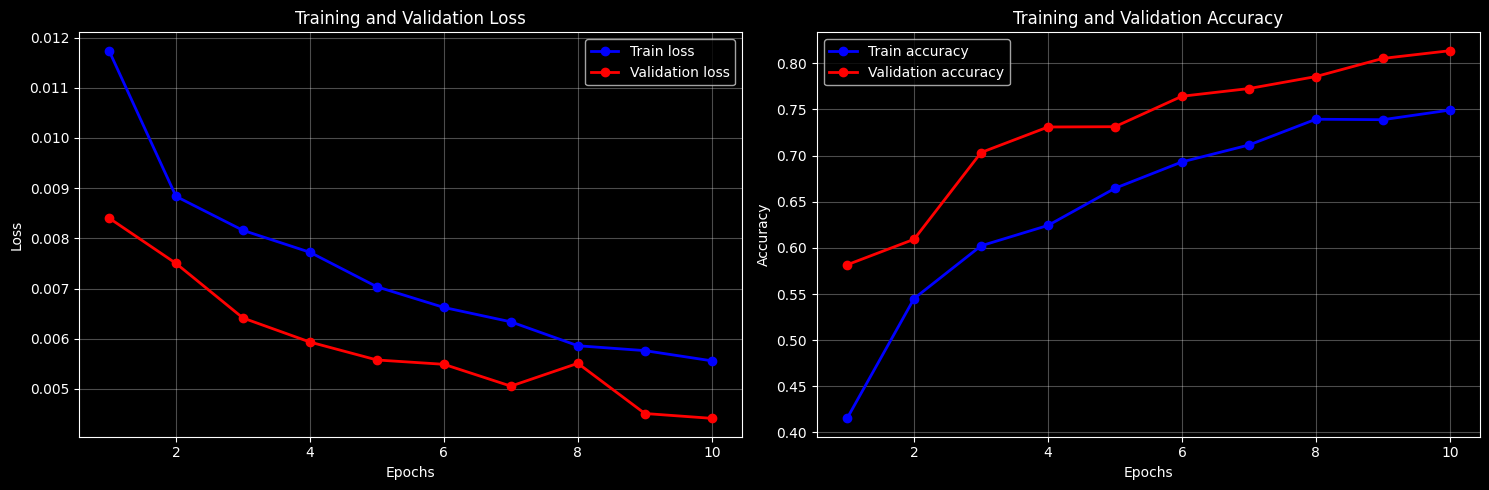

Final results
Best training accuracy: 74.93%
Best validation accuracy: 81.37%
Final train loss: 0.0056
Final validation loss: 0.0044


In [85]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.82it/s]


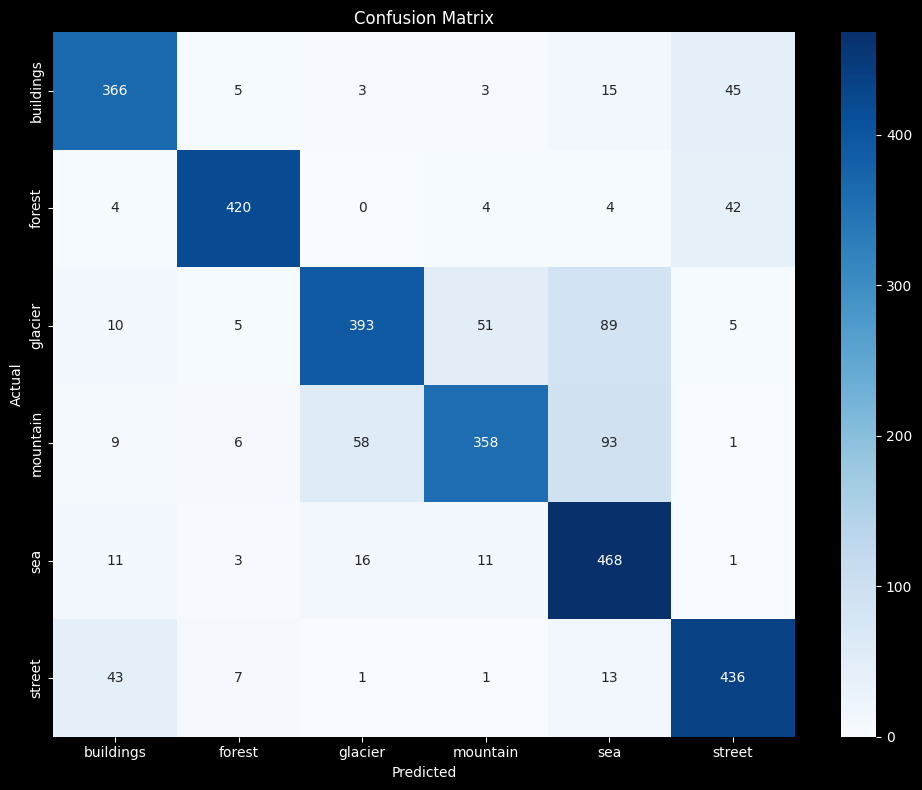


Точность по классам:
buildings: 0.838
forest: 0.886
glacier: 0.711
mountain: 0.682
sea: 0.918
street: 0.870


In [86]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [87]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.83      0.84      0.83       437
      forest       0.94      0.89      0.91       474
     glacier       0.83      0.71      0.77       553
    mountain       0.84      0.68      0.75       525
         sea       0.69      0.92      0.79       510
      street       0.82      0.87      0.85       501

    accuracy                           0.81      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.81      0.81      3000



### 50% аугментированных данных

In [88]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=0.5)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s, Loss=0.0093, Acc=49.67%]



Epoch 1/10:
Train Loss: 0.0128, Train Acc: 36.20%
Val Loss: 0.0093, Val Acc: 49.67%
Time: 74.9s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 49.67%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.80it/s, Loss=0.0078, Acc=57.77%]



Epoch 2/10:
Train Loss: 0.0098, Train Acc: 49.09%
Val Loss: 0.0078, Val Acc: 57.77%
Time: 74.6s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 57.77%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.99it/s, Loss=0.0086, Acc=57.90%]



Epoch 3/10:
Train Loss: 0.0090, Train Acc: 54.67%
Val Loss: 0.0086, Val Acc: 57.90%
Time: 74.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 57.90%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.96it/s, Loss=0.0074, Acc=66.43%]



Epoch 4/10:
Train Loss: 0.0085, Train Acc: 56.63%
Val Loss: 0.0074, Val Acc: 66.43%
Time: 74.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 66.43%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.09it/s, Loss=0.0067, Acc=68.17%]



Epoch 5/10:
Train Loss: 0.0082, Train Acc: 59.21%
Val Loss: 0.0067, Val Acc: 68.17%
Time: 73.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 68.17%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.98it/s, Loss=0.0067, Acc=67.77%]



Epoch 6/10:
Train Loss: 0.0080, Train Acc: 60.80%
Val Loss: 0.0067, Val Acc: 67.77%
Time: 73.8s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.64it/s, Loss=0.0065, Acc=71.17%]



Epoch 7/10:
Train Loss: 0.0075, Train Acc: 64.03%
Val Loss: 0.0065, Val Acc: 71.17%
Time: 75.0s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 71.17%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.74it/s, Loss=0.0057, Acc=76.07%]



Epoch 8/10:
Train Loss: 0.0072, Train Acc: 66.06%
Val Loss: 0.0057, Val Acc: 76.07%
Time: 77.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 76.07%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.08it/s, Loss=0.0060, Acc=72.83%]



Epoch 9/10:
Train Loss: 0.0069, Train Acc: 67.98%
Val Loss: 0.0060, Val Acc: 72.83%
Time: 74.0s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.77it/s, Loss=0.0052, Acc=76.37%]



Epoch 10/10:
Train Loss: 0.0066, Train Acc: 69.28%
Val Loss: 0.0052, Val Acc: 76.37%
Time: 78.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 76.37%
------------------------------------------------------------

Обучение завершено!
Общее время: 12.5 минут
Лучшая валидационная точность: 76.37%


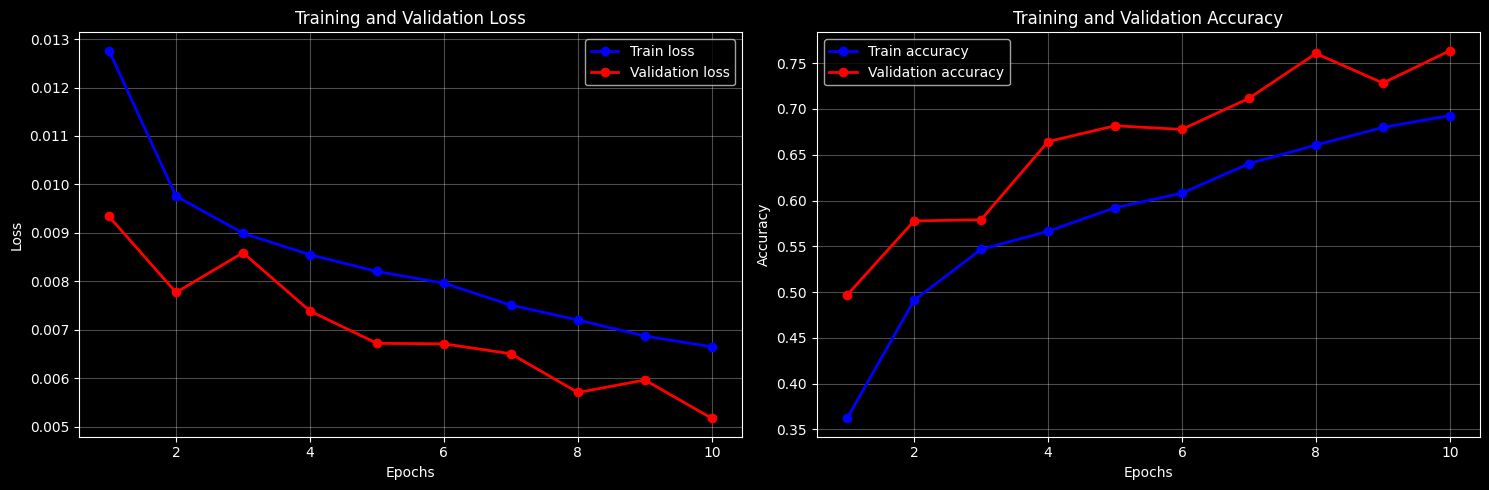

Final results
Best training accuracy: 69.28%
Best validation accuracy: 76.37%
Final train loss: 0.0066
Final validation loss: 0.0052


In [89]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.97it/s]


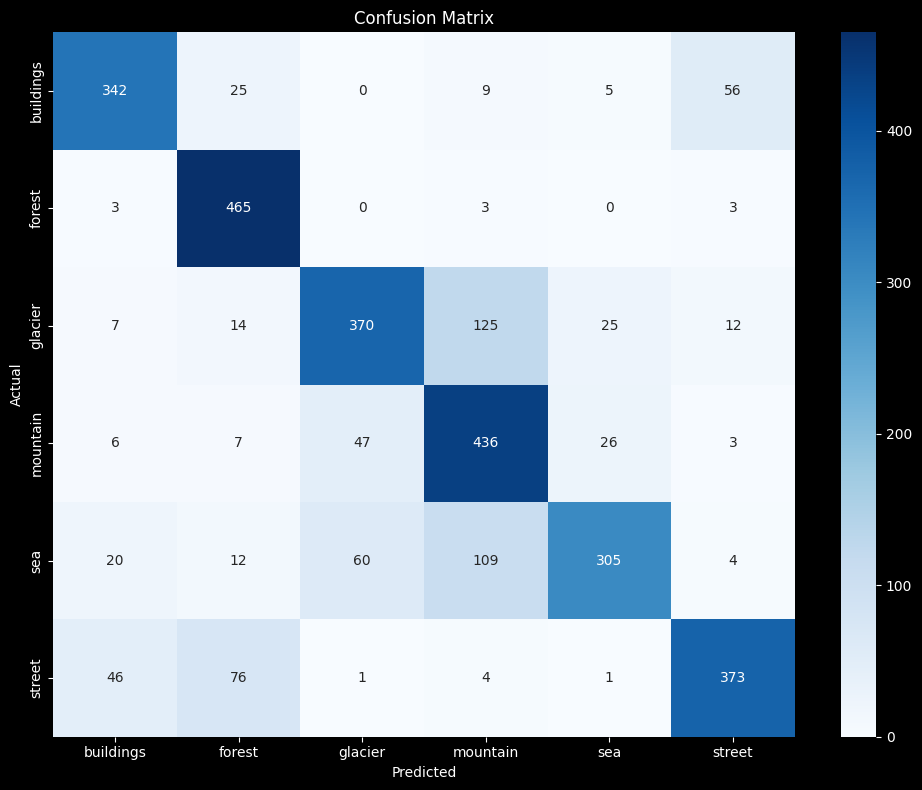


Точность по классам:
buildings: 0.783
forest: 0.981
glacier: 0.669
mountain: 0.830
sea: 0.598
street: 0.745


In [90]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [91]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.81      0.78      0.79       437
      forest       0.78      0.98      0.87       474
     glacier       0.77      0.67      0.72       553
    mountain       0.64      0.83      0.72       525
         sea       0.84      0.60      0.70       510
      street       0.83      0.74      0.78       501

    accuracy                           0.76      3000
   macro avg       0.78      0.77      0.76      3000
weighted avg       0.78      0.76      0.76      3000



### 75% аугментированных данных

In [92]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=0.75)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.69it/s, Loss=0.0113, Acc=43.93%]



Epoch 1/10:
Train Loss: 0.0137, Train Acc: 32.57%
Val Loss: 0.0113, Val Acc: 43.93%
Time: 101.7s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 43.93%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.96it/s, Loss=0.0081, Acc=60.27%]



Epoch 2/10:
Train Loss: 0.0103, Train Acc: 46.33%
Val Loss: 0.0081, Val Acc: 60.27%
Time: 100.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 60.27%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.95it/s, Loss=0.0079, Acc=60.23%]



Epoch 3/10:
Train Loss: 0.0093, Train Acc: 52.77%
Val Loss: 0.0079, Val Acc: 60.23%
Time: 100.4s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.69it/s, Loss=0.0075, Acc=65.40%]



Epoch 4/10:
Train Loss: 0.0087, Train Acc: 56.53%
Val Loss: 0.0075, Val Acc: 65.40%
Time: 102.1s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 65.40%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s, Loss=0.0076, Acc=65.07%]



Epoch 5/10:
Train Loss: 0.0083, Train Acc: 58.27%
Val Loss: 0.0076, Val Acc: 65.07%
Time: 100.2s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.92it/s, Loss=0.0070, Acc=66.90%]



Epoch 6/10:
Train Loss: 0.0082, Train Acc: 59.66%
Val Loss: 0.0070, Val Acc: 66.90%
Time: 98.6s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 66.90%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.78it/s, Loss=0.0080, Acc=61.93%]



Epoch 7/10:
Train Loss: 0.0080, Train Acc: 60.97%
Val Loss: 0.0080, Val Acc: 61.93%
Time: 100.4s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.89it/s, Loss=0.0066, Acc=69.63%]



Epoch 8/10:
Train Loss: 0.0077, Train Acc: 62.98%
Val Loss: 0.0066, Val Acc: 69.63%
Time: 101.8s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 69.63%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.64it/s, Loss=0.0069, Acc=68.50%]



Epoch 9/10:
Train Loss: 0.0076, Train Acc: 63.61%
Val Loss: 0.0069, Val Acc: 68.50%
Time: 102.6s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.79it/s, Loss=0.0061, Acc=69.83%]



Epoch 10/10:
Train Loss: 0.0073, Train Acc: 65.91%
Val Loss: 0.0061, Val Acc: 69.83%
Time: 101.2s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 69.83%
------------------------------------------------------------

Обучение завершено!
Общее время: 16.8 минут
Лучшая валидационная точность: 69.83%


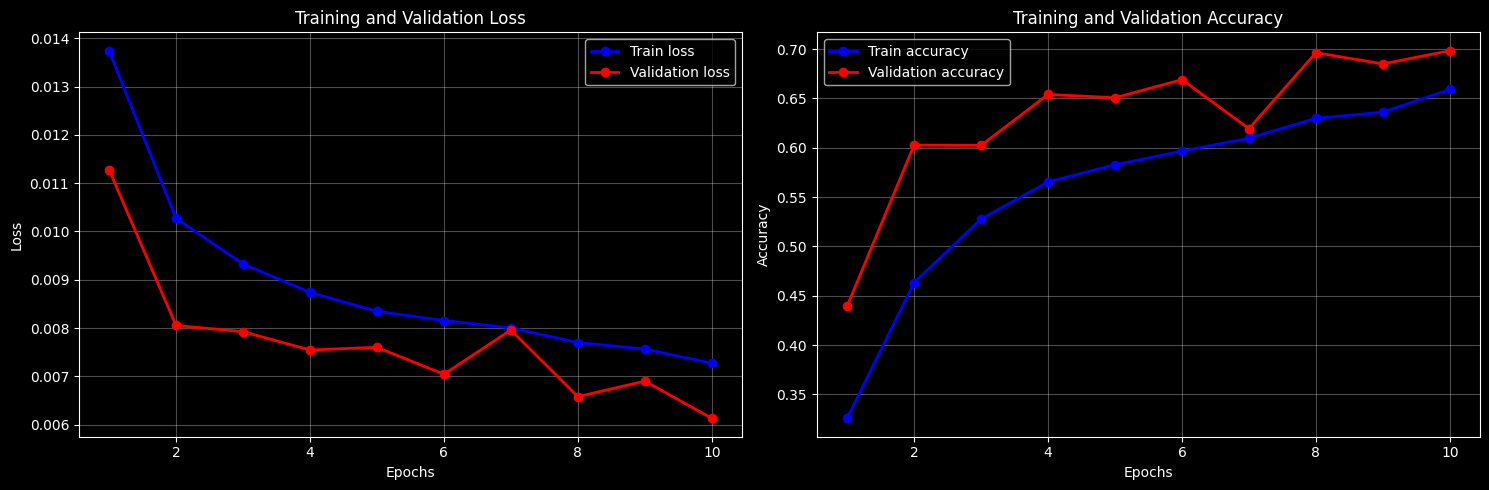

Final results
Best training accuracy: 65.91%
Best validation accuracy: 69.83%
Final train loss: 0.0073
Final validation loss: 0.0061


In [93]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.72it/s]


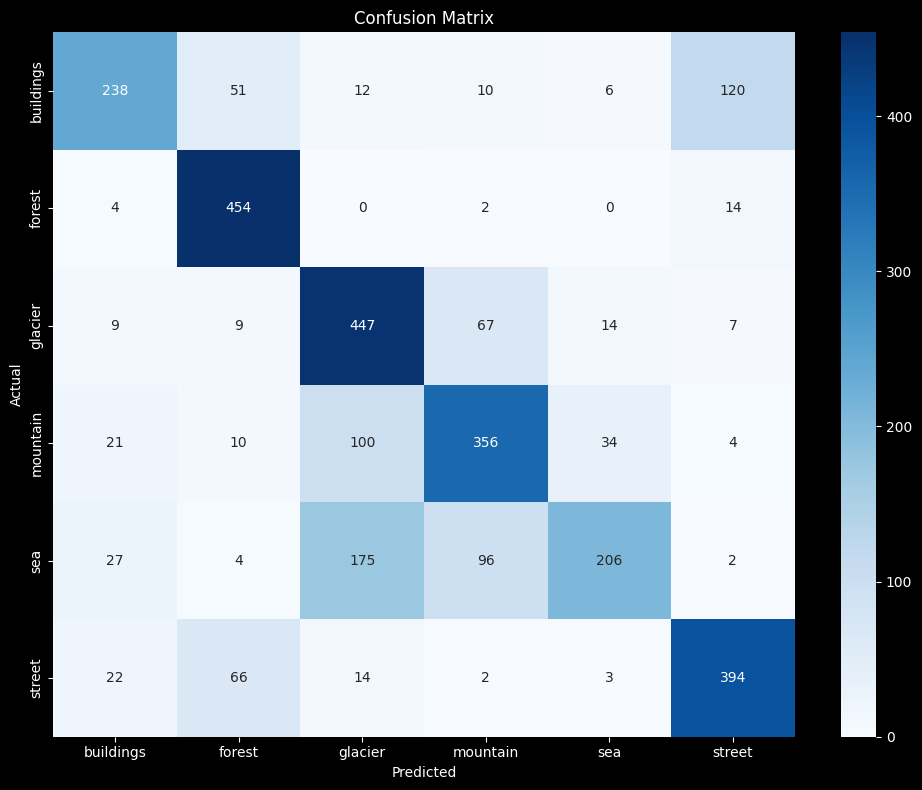


Точность по классам:
buildings: 0.545
forest: 0.958
glacier: 0.808
mountain: 0.678
sea: 0.404
street: 0.786


In [94]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [95]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.74      0.54      0.63       437
      forest       0.76      0.96      0.85       474
     glacier       0.60      0.81      0.69       553
    mountain       0.67      0.68      0.67       525
         sea       0.78      0.40      0.53       510
      street       0.73      0.79      0.76       501

    accuracy                           0.70      3000
   macro avg       0.71      0.70      0.69      3000
weighted avg       0.71      0.70      0.69      3000



### 100% аугментированных данных

In [96]:
# Создадим модель сверточной нейросети
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
history = run_experiment(model, criterion, optimizer, scheduler, ratio=1.0)

Начинаем обучение...


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.76it/s, Loss=0.0108, Acc=47.10%]



Epoch 1/10:
Train Loss: 0.0134, Train Acc: 35.05%
Val Loss: 0.0108, Val Acc: 47.10%
Time: 131.0s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 47.10%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.66it/s, Loss=0.0109, Acc=52.13%]



Epoch 2/10:
Train Loss: 0.0098, Train Acc: 49.19%
Val Loss: 0.0109, Val Acc: 52.13%
Time: 130.4s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 52.13%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s, Loss=0.0102, Acc=50.97%]



Epoch 3/10:
Train Loss: 0.0092, Train Acc: 52.67%
Val Loss: 0.0102, Val Acc: 50.97%
Time: 129.5s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.81it/s, Loss=0.0101, Acc=55.47%]



Epoch 4/10:
Train Loss: 0.0087, Train Acc: 56.66%
Val Loss: 0.0101, Val Acc: 55.47%
Time: 132.0s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 55.47%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.71it/s, Loss=0.0079, Acc=63.07%]



Epoch 5/10:
Train Loss: 0.0084, Train Acc: 58.85%
Val Loss: 0.0079, Val Acc: 63.07%
Time: 132.2s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 63.07%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.74it/s, Loss=0.0074, Acc=66.97%]



Epoch 6/10:
Train Loss: 0.0081, Train Acc: 60.80%
Val Loss: 0.0074, Val Acc: 66.97%
Time: 131.3s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 66.97%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.77it/s, Loss=0.0071, Acc=66.90%]



Epoch 7/10:
Train Loss: 0.0078, Train Acc: 62.31%
Val Loss: 0.0071, Val Acc: 66.90%
Time: 131.9s, LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.92it/s, Loss=0.0070, Acc=68.63%]



Epoch 8/10:
Train Loss: 0.0077, Train Acc: 63.49%
Val Loss: 0.0070, Val Acc: 68.63%
Time: 130.8s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 68.63%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.75it/s, Loss=0.0064, Acc=70.87%]



Epoch 9/10:
Train Loss: 0.0075, Train Acc: 64.36%
Val Loss: 0.0064, Val Acc: 70.87%
Time: 133.5s, LR: 0.001000
★ Новая лучшая модель! Accuracy: 70.87%
------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.73it/s, Loss=0.0071, Acc=67.07%]


Epoch 10/10:
Train Loss: 0.0072, Train Acc: 66.08%
Val Loss: 0.0071, Val Acc: 67.07%
Time: 134.3s, LR: 0.001000
------------------------------------------------------------

Обучение завершено!
Общее время: 22.0 минут
Лучшая валидационная точность: 70.87%


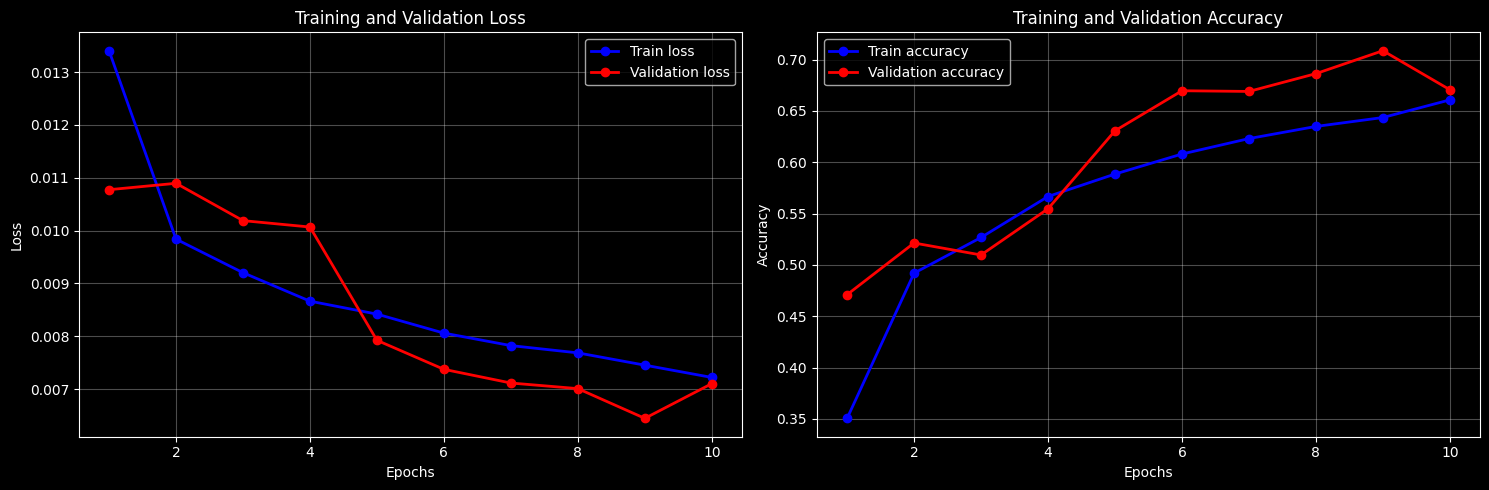

Final results
Best training accuracy: 66.08%
Best validation accuracy: 70.87%
Final train loss: 0.0072
Final validation loss: 0.0071


In [97]:
# Графики потерь и точности
plot_training_history(history)

Evaluation: 100%|██████████| 24/24 [00:06<00:00,  3.86it/s]


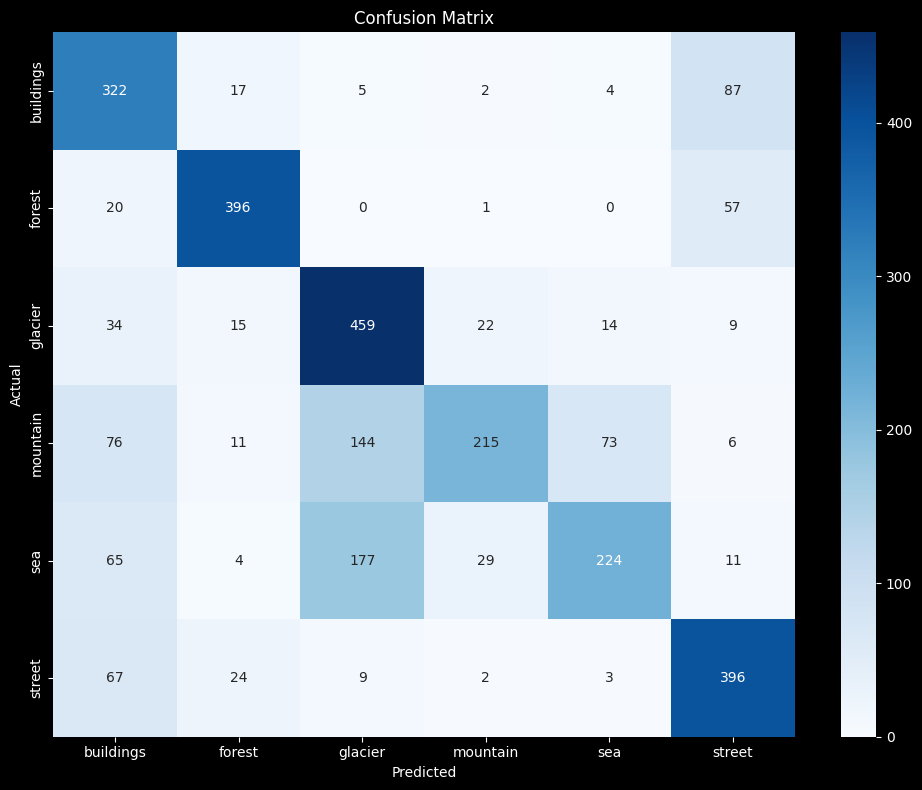


Точность по классам:
buildings: 0.737
forest: 0.835
glacier: 0.830
mountain: 0.410
sea: 0.439
street: 0.790


In [98]:
y_true, y_pred, y_proba = evaluate_model(model, val_loader) # Оценка на тестовом наборе
plot_confusion_matrix(y_true, y_pred, classes) # Матрица ошибок

In [99]:
# Отчет по классификации
print("Детальный отчет:")
print(classification_report(y_true, y_pred, target_names=classes))

Детальный отчет:
              precision    recall  f1-score   support

   buildings       0.55      0.74      0.63       437
      forest       0.85      0.84      0.84       474
     glacier       0.58      0.83      0.68       553
    mountain       0.79      0.41      0.54       525
         sea       0.70      0.44      0.54       510
      street       0.70      0.79      0.74       501

    accuracy                           0.67      3000
   macro avg       0.70      0.67      0.66      3000
weighted avg       0.70      0.67      0.66      3000



# Исследовательские вопросы для анализа

## 1. Какое соотношение аугментированных данных к исходным является оптимальным?

Итак, методы аугментации данных позволяют искусственно расширять обучающую выборку за счёт различных преобразований исходных изображений. Исходя из результатов эксперимента (см. график ниже) можем судить о том, что соотношение ~25% аугментированных данных к оригинальным - оптимальное. Мы видим стабильное поведение F1-score на всех этапах проверки и высокое качество модели. При более низком проценте наблюдается недообучение

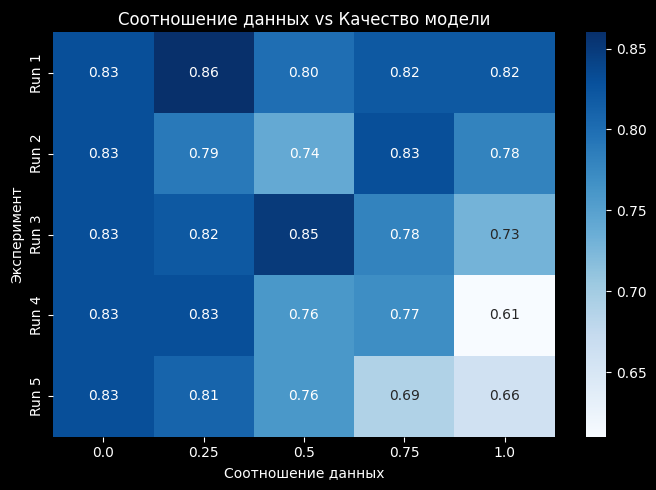

In [102]:
ratios = np.array([0., 0.25, 0.5, 0.75, 1.0])
scores = np.array([[0.83, 0.86, 0.80, 0.82, 0.82],  # Weighted F1-score на этапе 1
                   [0.83, 0.79, 0.74, 0.83, 0.78],  # Weighted F1-score на этапе 2
                   [0.83, 0.82, 0.85, 0.78, 0.73],  # Weighted F1-score на этапе 3
                   [0.83, 0.83, 0.76, 0.77, 0.61],  # Weighted F1-score на этапе 4
                   [0.83, 0.81, 0.76, 0.69, 0.66]]) # Weighted F1-score на этапе 5

plt.figure(figsize=(7,5))
sns.heatmap(scores, annot=True, cmap='Blues', fmt=".2f",
            xticklabels=ratios, yticklabels=[f"Run {i+1}" for i in range(scores.shape[0])])
plt.title("Соотношение данных vs Качество модели")
plt.xlabel("Соотношение данных")
plt.ylabel("Эксперимент")
plt.tight_layout()
plt.show()

## 2. Зависит ли качество предсказаний от количества различных способов аугментации?

Зависимость между **количеством аугментаций** и **качеством предсказаний** есть.

F1-score показывает тренд на снижение, несмотря на небольшой рост на 3 этапе (см. график ниже). Можно утверждать, что начиная с 6 аугментаций дальнейшее их увеличение ведёт к ухудшению качества модели

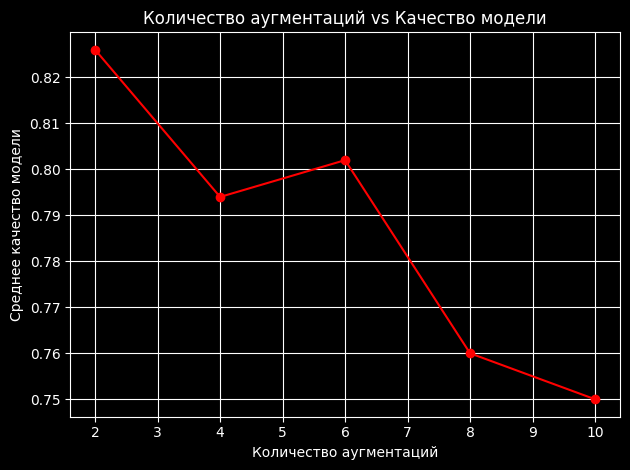

In [106]:
mean_scores = scores.mean(axis=1)

plt.plot([2, 4, 6, 8, 10], mean_scores, marker='o', color='r')
plt.title("Количество аугментаций vs Качество модели")
plt.xlabel("Количество аугментаций")
plt.ylabel("Среднее качество модели")

plt.grid(True)
plt.tight_layout()
plt.show()

## 3. На каком этапе добавления аугментаций наблюдается наибольший прирост качества?

Наибольший прирост качества можно заметить на 3 этапе (см. график выше). 

Большее число аугментаций на референсе выдает значение похуже. 

## 4. Есть ли признак переобучения при использовании слишком агрессивных аугментаций?

Переобучение характеризуется тем, что модель "запоминает" тренирововчные данные, а не выявлет паттерны, тем самым показывая высокие результаты на тренировочной выборке, но низкие результаты на валидационной выборке.

В целом, аугментации наоборот помогают бороться с переобучением, засчет увеличения разнообразия выборки. Самые агрессивные аугментации (Erasing, CutMix) - делают изображения чересчур нереалистичными, модель учится на искажённых примерах, подстраивается под них и выдает низкие значения, причем и на train, и на valid, что говорит нам о недообучении, а не о переобучении